In [1]:
import sys
sys.path.append('../')

In [2]:

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader
from diffusion_policy.dataset.robomimic_replay_image_dataset import RobomimicReplayImageDataset
from diffusion_policy.dataset.robomimic_replay_lowdim_dataset import RobomimicReplayLowdimDataset
from diffusion_policy.model.common.normalizer import LinearNormalizer

In [3]:
lowdim_dataset_path = "../data/robomimic/datasets/lift/ph/low_dim_abs_with_attention_right.hdf5"
lowdim_dataset = RobomimicReplayLowdimDataset(lowdim_dataset_path, horizon=16, pad_before=1, pad_after=7, obs_keys=['object', 'robot0_eef_pos', 'robot0_eef_quat', 'robot0_gripper_qpos', 'spatial_attention'], abs_action=True, rotation_rep='rotation_6d', use_legacy_normalizer=False, seed=42, val_ratio=0.02, max_train_episodes=None)
val_dataset = lowdim_dataset.get_validation_dataset()

train_dataloader = DataLoader(lowdim_dataset, batch_size=256, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=256, shuffle=False)

display_dataloader = DataLoader(
    RobomimicReplayLowdimDataset(lowdim_dataset_path, horizon=16, pad_before=1, pad_after=7, obs_keys=['object', 'robot0_eef_pos', 'robot0_eef_quat', 'robot0_gripper_qpos', 'spatial_attention'], abs_action=True, rotation_rep='rotation_6d', use_legacy_normalizer=False, seed=42, val_ratio=0.0, max_train_episodes=None),
    batch_size=1,
    shuffle=False
)

normalizer = LinearNormalizer()
# normalizer = lowdim_dataset.get_normalizer()
# print(normalizer.state_dict())
normalizer.load_state_dict(torch.load("../data/outputs/lift_lowdim_ph_reproduction/horizon_16/2025.03.11/10.57.22_train_diffusion_unet_lowdim_lift_lowdim_transformer_128/checkpoints/normalizer.pth"))
# torch.save(normalizer.state_dict(), "../data/outputs/lift_lowdim_ph_reproduction/horizon_16/2025.03.11/10.57.22_train_diffusion_unet_lowdim_lift_lowdim_transformer_128/checkpoints/normalizer.pth")


Loading hdf5 to ReplayBuffer: 100%|██████████| 200/200 [00:00<00:00, 1319.25it/s]


<All keys matched successfully>

In [4]:
class Seq2SeqTransformer(nn.Module):
    def __init__(self, obs_dim=38, action_dim=10, seq_len=16, d_model=128, nhead=4, num_layers=2):
        super().__init__()
        self.seq_len = seq_len
        self.obs_proj = nn.Linear(obs_dim, d_model)
        self.action_proj = nn.Linear(action_dim, d_model)

        self.pos_embedding = nn.Parameter(torch.randn(seq_len, d_model))

        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.decoder = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Linear(d_model, 1)
        )

    def forward(self, obs, action_seq):
        # obs: (B, 38), action_seq: (B, 16, 10)
        B = obs.size(0)

        # Project inputs
        obs_emb = self.obs_proj(obs)  # (B, d_model)
        obs_emb = obs_emb.unsqueeze(1).expand(-1, self.seq_len, -1)  # (B, 16, d_model)

        action_emb = self.action_proj(action_seq)  # (B, 16, d_model)

        # Combine observation embedding with action sequence embedding
        x = obs_emb + action_emb + self.pos_embedding.unsqueeze(0)  # (B, 16, d_model)

        # Encode
        encoded = self.encoder(x)  # (B, 16, d_model)

        # Decode to (B, 16, 1)
        output = self.decoder(encoded)
        return output

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

train_data_sample = next(iter(train_dataloader))

train_data_sample.keys()
obs_dim = (train_data_sample['obs'].shape[-1]-1)*2
action_dim = train_data_sample['action'].shape[-1]
seq_len = train_data_sample['action'].shape[1]

model = Seq2SeqTransformer(obs_dim=obs_dim, action_dim=action_dim, seq_len=seq_len)
model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

best_val_loss = float('inf')

for epoch in range(100):
    for batch in train_dataloader:
        
        optimizer.zero_grad()
        
        B, T, D = batch['obs'].shape
        nobs = normalizer['obs'].unnormalize(batch['obs'])
        naction = normalizer['action'].unnormalize(batch['action'])
        
        obs = nobs[:, :2, :-1].reshape(B, -1).to(device)
        action_seq = naction.to(device)
        attention = nobs[:, :, -1].unsqueeze(-1).to(device)
        
        output = model(obs, action_seq)
        loss = criterion(output, attention)
        
        loss.backward()
        optimizer.step()
        
    print(f"Epoch {epoch}, Loss: {loss.item()}")
        
    for batch in val_dataloader:
        val_loss = 0
        with torch.no_grad():
            B, T, D = batch['obs'].shape
            nobs = normalizer['obs'].unnormalize(batch['obs'])
            naction = normalizer['action'].unnormalize(batch['action'])
            
            obs = nobs[:, :2, :-1].reshape(B, -1).to(device)
            action_seq = naction.to(device)
            attention = nobs[:, :, -1].unsqueeze(-1).to(device)
            
            output = model(obs, action_seq)
            loss = criterion(output, attention)
            val_loss += loss.item()
    val_loss /= len(val_dataloader)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_val_state_dict = model.state_dict()
    print(f"Best val loss: {best_val_loss}")    
        

Epoch 0, Loss: 0.041012927889823914
Best val loss: 0.023409118875861168
Epoch 1, Loss: 0.04119120165705681
Best val loss: 0.015568865463137627
Epoch 2, Loss: 0.04106459394097328
Best val loss: 0.013019075617194176
Epoch 3, Loss: 0.03732946515083313
Best val loss: 0.013019075617194176
Epoch 4, Loss: 0.03063589707016945
Best val loss: 0.013019075617194176
Epoch 5, Loss: 0.027289213612675667
Best val loss: 0.013019075617194176
Epoch 6, Loss: 0.024714328348636627
Best val loss: 0.013019075617194176
Epoch 7, Loss: 0.02453836053609848
Best val loss: 0.013019075617194176
Epoch 8, Loss: 0.02486075460910797
Best val loss: 0.013019075617194176
Epoch 9, Loss: 0.024531245231628418
Best val loss: 0.012174192816019058
Epoch 10, Loss: 0.023891307413578033
Best val loss: 0.011497306637465954
Epoch 11, Loss: 0.0233427993953228
Best val loss: 0.011127153411507607
Epoch 12, Loss: 0.02272271178662777
Best val loss: 0.010783515870571136
Epoch 13, Loss: 0.02248244360089302
Best val loss: 0.01065526995807886

In [6]:
iterator = iter(display_dataloader)
idx = np.random.randint(0, len(display_dataloader))
print(idx)
for _ in range(idx):
    batch = next(iterator)
    
model.load_state_dict(best_val_state_dict)

with torch.no_grad():
    B, T, D = batch['obs'].shape
    nobs = normalizer['obs'].unnormalize(batch['obs']).to(device)
    naction = normalizer['action'].unnormalize(batch['action']).to(device)
    
    obs = nobs[:, :2, :-1].reshape(B, -1).to(device)
    action_seq = naction.to(device)
    attention = nobs[:, :, -1].unsqueeze(-1).to(device)
    
    output = model(obs, action_seq)
    loss = criterion(output, attention)
    
    print(f"Loss: {loss.item()}")
    
    attention_pred = normalizer['obs'].normalize(torch.cat([nobs[:, :, :-1], output], dim=-1))[:, :, -1].detach().cpu().numpy()


2053
Loss: 0.0008660713210701942


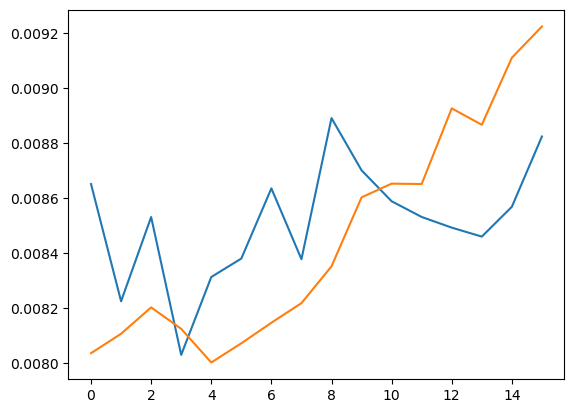

In [7]:
from matplotlib import pyplot as plt
plt.plot(attention_pred[0])
plt.plot(batch['obs'][0, :, -1])

In [49]:
# torch.save(model.state_dict(), "../data/outputs/lift_lowdim_ph_reproduction/horizon_16/2025.03.11/10.57.22_train_diffusion_unet_lowdim_lift_lowdim_transformer_128/checkpoints/epoch=0200-transformer_attention_estimator.pth")

In [23]:
# Now plot both true attention and predicted attention
import os

# zarr_path = os.path.expanduser('../data/robomimic/datasets/lift/ph/image_abs.hdf5.zarr.zip')
dataset_path = os.path.expanduser('../data/robomimic/datasets/lift/ph/image_abs.hdf5')
# replay_buffer = ReplayBuffer.copy_from_path(zarr_path, keys=None)

# Define shape metadata
shape_meta = {
    'action': {
        'shape': [7]
    },
    'obs': {
        'object': {
            'shape': [10]
        },
        'agentview_image': {
            'shape': [3, 84, 84],
            'type': 'rgb'
        },
        'robot0_eef_pos': {
            'shape': [3]
        },
        'robot0_eef_quat': {
            'shape': [4]
        },
        'robot0_eye_in_hand_image': {
            'shape': [3, 84, 84],
            'type': 'rgb'
        },
        'robot0_gripper_qpos': {
            'shape': [2]
        }
    }
}

# Create dataset
image_dataset = RobomimicReplayImageDataset(
    dataset_path=dataset_path,
    shape_meta=shape_meta,
    horizon=2,
    pad_before=1,
    pad_after=1,
    rotation_rep='rotation_6d',
    seed=42,
    val_ratio=0.0,
    use_legacy_normalizer=False,
)

img_dataloader = DataLoader(image_dataset, batch_size=1, shuffle=False)
img_iterator = iter(img_dataloader)

display_dataloader = DataLoader(
    RobomimicReplayLowdimDataset(lowdim_dataset_path, horizon=16, pad_before=1, pad_after=15, obs_keys=['object', 'robot0_eef_pos', 'robot0_eef_quat', 'robot0_gripper_qpos', 'spatial_attention'], abs_action=True, rotation_rep='rotation_6d', use_legacy_normalizer=False, seed=42, val_ratio=0.0, max_train_episodes=None),
    batch_size=1,
    shuffle=False
)

normalizer = lowdim_dataset.get_normalizer()

assert len(display_dataloader) == len(img_dataloader)

Loading lowdim data:   0%|          | 0/5 [00:00<?, ?it/s]

Loading hdf5 to ReplayBuffer: 100%|██████████| 200/200 [00:00<00:00, 1365.58it/s]


  0%|          | 0/200 [00:04<?, ?it/s]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_0.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_0.mp4



  0%|          | 1/200 [00:04<14:46,  4.46s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_0.mp4


  0%|          | 1/200 [00:08<14:46,  4.46s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_1.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_1.mp4



  1%|          | 2/200 [00:08<14:04,  4.26s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_1.mp4


  1%|          | 2/200 [00:12<14:04,  4.26s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_2.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_2.mp4



  2%|▏         | 3/200 [00:12<13:54,  4.24s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_2.mp4


  2%|▏         | 3/200 [00:16<13:54,  4.24s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_3.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_3.mp4



  2%|▏         | 4/200 [00:16<13:21,  4.09s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_3.mp4


  2%|▏         | 4/200 [00:20<13:21,  4.09s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_4.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_4.mp4



  2%|▎         | 5/200 [00:20<12:46,  3.93s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_4.mp4


  2%|▎         | 5/200 [00:24<12:46,  3.93s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_5.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_5.mp4



  3%|▎         | 6/200 [00:24<13:03,  4.04s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_5.mp4


  3%|▎         | 6/200 [00:27<13:03,  4.04s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_6.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_6.mp4



  4%|▎         | 7/200 [00:27<12:13,  3.80s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_6.mp4


  4%|▎         | 7/200 [00:31<12:13,  3.80s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_7.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_7.mp4



  4%|▍         | 8/200 [00:31<11:50,  3.70s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_7.mp4


  4%|▍         | 8/200 [00:33<11:50,  3.70s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_8.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_8.mp4



  4%|▍         | 9/200 [00:34<10:53,  3.42s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_8.mp4


  4%|▍         | 9/200 [00:38<10:53,  3.42s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_9.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_9.mp4



  5%|▌         | 10/200 [00:38<11:35,  3.66s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_9.mp4


  5%|▌         | 10/200 [00:42<11:35,  3.66s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_10.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_10.mp4



  6%|▌         | 11/200 [00:42<11:56,  3.79s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_10.mp4


  6%|▌         | 11/200 [00:45<11:56,  3.79s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_11.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_11.mp4



  6%|▌         | 12/200 [00:45<11:21,  3.63s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_11.mp4


  6%|▌         | 12/200 [00:49<11:21,  3.63s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_12.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_12.mp4



  6%|▋         | 13/200 [00:49<11:30,  3.69s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_12.mp4


  6%|▋         | 13/200 [00:53<11:30,  3.69s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_13.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_13.mp4



  7%|▋         | 14/200 [00:53<12:07,  3.91s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_13.mp4


  7%|▋         | 14/200 [00:57<12:07,  3.91s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_14.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_14.mp4



  8%|▊         | 15/200 [00:57<11:45,  3.81s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_14.mp4


  8%|▊         | 15/200 [01:00<11:45,  3.81s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_15.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_15.mp4



  8%|▊         | 16/200 [01:00<11:20,  3.70s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_15.mp4


  8%|▊         | 16/200 [01:04<11:20,  3.70s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_16.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_16.mp4



  8%|▊         | 17/200 [01:04<10:53,  3.57s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_16.mp4


  8%|▊         | 17/200 [01:06<10:53,  3.57s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_17.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_17.mp4



  9%|▉         | 18/200 [01:07<10:06,  3.33s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_17.mp4


  9%|▉         | 18/200 [01:10<10:06,  3.33s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_18.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_18.mp4



 10%|▉         | 19/200 [01:10<10:06,  3.35s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_18.mp4


 10%|▉         | 19/200 [01:13<10:06,  3.35s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_19.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_19.mp4



 10%|█         | 20/200 [01:13<10:08,  3.38s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_19.mp4


 10%|█         | 20/200 [01:16<10:08,  3.38s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_20.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_20.mp4



 10%|█         | 21/200 [01:16<09:46,  3.28s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_20.mp4


 10%|█         | 21/200 [01:20<09:46,  3.28s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_21.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_21.mp4



 11%|█         | 22/200 [01:20<10:18,  3.47s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_21.mp4


 11%|█         | 22/200 [01:23<10:18,  3.47s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_22.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_22.mp4



 12%|█▏        | 23/200 [01:24<10:02,  3.40s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_22.mp4


 12%|█▏        | 23/200 [01:27<10:02,  3.40s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_23.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_23.mp4



 12%|█▏        | 24/200 [01:27<09:50,  3.36s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_23.mp4


 12%|█▏        | 24/200 [01:31<09:50,  3.36s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_24.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_24.mp4



 12%|█▎        | 25/200 [01:31<10:21,  3.55s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_24.mp4


 12%|█▎        | 25/200 [01:34<10:21,  3.55s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_25.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_25.mp4



 13%|█▎        | 26/200 [01:34<09:57,  3.43s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_25.mp4


 13%|█▎        | 26/200 [01:37<09:57,  3.43s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_26.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_26.mp4



 14%|█▎        | 27/200 [01:37<09:19,  3.23s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_26.mp4


 14%|█▎        | 27/200 [01:39<09:19,  3.23s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_27.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_27.mp4



 14%|█▍        | 28/200 [01:40<09:00,  3.14s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_27.mp4


 14%|█▍        | 28/200 [01:43<09:00,  3.14s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_28.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_28.mp4



 14%|█▍        | 29/200 [01:43<08:58,  3.15s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_28.mp4


 14%|█▍        | 29/200 [01:45<08:58,  3.15s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_29.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_29.mp4



 15%|█▌        | 30/200 [01:45<08:23,  2.96s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_29.mp4


 15%|█▌        | 30/200 [01:48<08:23,  2.96s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_30.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_30.mp4



 16%|█▌        | 31/200 [01:48<08:27,  3.00s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_30.mp4


 16%|█▌        | 31/200 [01:51<08:27,  3.00s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_31.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_31.mp4



 16%|█▌        | 32/200 [01:51<08:01,  2.87s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_31.mp4


 16%|█▌        | 32/200 [01:55<08:01,  2.87s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_32.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_32.mp4



 16%|█▋        | 33/200 [01:55<09:16,  3.33s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_32.mp4


 16%|█▋        | 33/200 [01:59<09:16,  3.33s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_33.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_33.mp4



 17%|█▋        | 34/200 [01:59<09:46,  3.53s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_33.mp4


 17%|█▋        | 34/200 [02:02<09:46,  3.53s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_34.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_34.mp4



 18%|█▊        | 35/200 [02:02<09:19,  3.39s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_34.mp4


 18%|█▊        | 35/200 [02:07<09:19,  3.39s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_35.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_35.mp4



 18%|█▊        | 36/200 [02:07<09:59,  3.65s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_35.mp4


 18%|█▊        | 36/200 [02:09<09:59,  3.65s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_36.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_36.mp4



 18%|█▊        | 37/200 [02:10<09:20,  3.44s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_36.mp4


 18%|█▊        | 37/200 [02:13<09:20,  3.44s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_37.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_37.mp4



 19%|█▉        | 38/200 [02:13<09:13,  3.42s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_37.mp4


 19%|█▉        | 38/200 [02:16<09:13,  3.42s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_38.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_38.mp4



 20%|█▉        | 39/200 [02:16<09:07,  3.40s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_38.mp4


 20%|█▉        | 39/200 [02:19<09:07,  3.40s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_39.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_39.mp4



 20%|██        | 40/200 [02:19<08:22,  3.14s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_39.mp4


 20%|██        | 40/200 [02:21<08:22,  3.14s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_40.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_40.mp4



 20%|██        | 41/200 [02:21<07:44,  2.92s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_40.mp4


 20%|██        | 41/200 [02:24<07:44,  2.92s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_41.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_41.mp4



 21%|██        | 42/200 [02:25<08:00,  3.04s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_41.mp4


 21%|██        | 42/200 [02:28<08:00,  3.04s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_42.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_42.mp4



 22%|██▏       | 43/200 [02:28<08:28,  3.24s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_42.mp4


 22%|██▏       | 43/200 [02:31<08:28,  3.24s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_43.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_43.mp4



 22%|██▏       | 44/200 [02:31<08:05,  3.11s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_43.mp4


 22%|██▏       | 44/200 [02:34<08:05,  3.11s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_44.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_44.mp4



 22%|██▎       | 45/200 [02:34<08:02,  3.11s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_44.mp4


 22%|██▎       | 45/200 [02:37<08:02,  3.11s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_45.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_45.mp4



 23%|██▎       | 46/200 [02:38<08:05,  3.15s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_45.mp4


 23%|██▎       | 46/200 [02:40<08:05,  3.15s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_46.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_46.mp4



 24%|██▎       | 47/200 [02:41<07:56,  3.11s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_46.mp4


 24%|██▎       | 47/200 [02:43<07:56,  3.11s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_47.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_47.mp4



 24%|██▍       | 48/200 [02:43<07:27,  2.95s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_47.mp4


 24%|██▍       | 48/200 [02:47<07:27,  2.95s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_48.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_48.mp4



 24%|██▍       | 49/200 [02:47<08:07,  3.23s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_48.mp4


 24%|██▍       | 49/200 [02:50<08:07,  3.23s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_49.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_49.mp4



 25%|██▌       | 50/200 [02:50<07:56,  3.18s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_49.mp4


 25%|██▌       | 50/200 [02:53<07:56,  3.18s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_50.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_50.mp4



 26%|██▌       | 51/200 [02:53<07:34,  3.05s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_50.mp4


 26%|██▌       | 51/200 [02:56<07:34,  3.05s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_51.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_51.mp4



 26%|██▌       | 52/200 [02:56<07:41,  3.12s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_51.mp4


 26%|██▌       | 52/200 [02:59<07:41,  3.12s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_52.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_52.mp4



 26%|██▋       | 53/200 [02:59<07:33,  3.09s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_52.mp4


 26%|██▋       | 53/200 [03:03<07:33,  3.09s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_53.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_53.mp4



 27%|██▋       | 54/200 [03:03<08:07,  3.34s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_53.mp4


 27%|██▋       | 54/200 [03:06<08:07,  3.34s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_54.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_54.mp4



 28%|██▊       | 55/200 [03:06<07:39,  3.17s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_54.mp4


 28%|██▊       | 55/200 [03:10<07:39,  3.17s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_55.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_55.mp4



 28%|██▊       | 56/200 [03:10<08:15,  3.44s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_55.mp4


 28%|██▊       | 56/200 [03:12<08:15,  3.44s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_56.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_56.mp4



 28%|██▊       | 57/200 [03:12<07:29,  3.15s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_56.mp4


 28%|██▊       | 57/200 [03:14<07:29,  3.15s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_57.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_57.mp4



 29%|██▉       | 58/200 [03:15<06:46,  2.86s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_57.mp4


 29%|██▉       | 58/200 [03:17<06:46,  2.86s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_58.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_58.mp4



 30%|██▉       | 59/200 [03:17<06:16,  2.67s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_58.mp4


 30%|██▉       | 59/200 [03:19<06:16,  2.67s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_59.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_59.mp4



 30%|███       | 60/200 [03:19<06:12,  2.66s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_59.mp4


 30%|███       | 60/200 [03:22<06:12,  2.66s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_60.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_60.mp4



 30%|███       | 61/200 [03:22<05:59,  2.59s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_60.mp4


 30%|███       | 61/200 [03:25<05:59,  2.59s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_61.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_61.mp4



 31%|███       | 62/200 [03:26<06:50,  2.97s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_61.mp4


 31%|███       | 62/200 [03:28<06:50,  2.97s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_62.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_62.mp4



 32%|███▏      | 63/200 [03:28<06:27,  2.83s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_62.mp4


 32%|███▏      | 63/200 [03:30<06:27,  2.83s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_63.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_63.mp4



 32%|███▏      | 64/200 [03:31<06:11,  2.73s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_63.mp4


 32%|███▏      | 64/200 [03:34<06:11,  2.73s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_64.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_64.mp4



 32%|███▎      | 65/200 [03:35<06:53,  3.06s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_64.mp4


 32%|███▎      | 65/200 [03:37<06:53,  3.06s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_65.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_65.mp4



 33%|███▎      | 66/200 [03:37<06:20,  2.84s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_65.mp4


 33%|███▎      | 66/200 [03:39<06:20,  2.84s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_66.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_66.mp4



 34%|███▎      | 67/200 [03:39<06:05,  2.75s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_66.mp4


 34%|███▎      | 67/200 [03:42<06:05,  2.75s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_67.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_67.mp4



 34%|███▍      | 68/200 [03:42<05:57,  2.71s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_67.mp4


 34%|███▍      | 68/200 [03:44<05:57,  2.71s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_68.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_68.mp4



 34%|███▍      | 69/200 [03:44<05:40,  2.60s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_68.mp4


 34%|███▍      | 69/200 [03:47<05:40,  2.60s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_69.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_69.mp4



 35%|███▌      | 70/200 [03:48<06:00,  2.77s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_69.mp4


 35%|███▌      | 70/200 [03:50<06:00,  2.77s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_70.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_70.mp4



 36%|███▌      | 71/200 [03:51<06:08,  2.85s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_70.mp4


 36%|███▌      | 71/200 [03:53<06:08,  2.85s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_71.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_71.mp4



 36%|███▌      | 72/200 [03:54<06:08,  2.88s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_71.mp4


 36%|███▌      | 72/200 [03:56<06:08,  2.88s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_72.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_72.mp4



 36%|███▋      | 73/200 [03:56<05:41,  2.69s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_72.mp4


 36%|███▋      | 73/200 [03:58<05:41,  2.69s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_73.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_73.mp4



 37%|███▋      | 74/200 [03:58<05:14,  2.49s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_73.mp4


 37%|███▋      | 74/200 [04:01<05:14,  2.49s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_74.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_74.mp4



 38%|███▊      | 75/200 [04:01<05:35,  2.68s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_74.mp4


 38%|███▊      | 75/200 [04:03<05:35,  2.68s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_75.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_75.mp4



 38%|███▊      | 76/200 [04:03<05:11,  2.51s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_75.mp4


 38%|███▊      | 76/200 [04:06<05:11,  2.51s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_76.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_76.mp4



 38%|███▊      | 77/200 [04:06<05:34,  2.72s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_76.mp4


 38%|███▊      | 77/200 [04:08<05:34,  2.72s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_77.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_77.mp4



 39%|███▉      | 78/200 [04:08<05:14,  2.58s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_77.mp4


 39%|███▉      | 78/200 [04:11<05:14,  2.58s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_78.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_78.mp4



 40%|███▉      | 79/200 [04:11<05:19,  2.64s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_78.mp4


 40%|███▉      | 79/200 [04:14<05:19,  2.64s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_79.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_79.mp4



 40%|████      | 80/200 [04:14<05:22,  2.69s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_79.mp4


 40%|████      | 80/200 [04:16<05:22,  2.69s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_80.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_80.mp4



 40%|████      | 81/200 [04:17<05:15,  2.65s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_80.mp4


 40%|████      | 81/200 [04:19<05:15,  2.65s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_81.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_81.mp4



 41%|████      | 82/200 [04:19<04:57,  2.52s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_81.mp4


 41%|████      | 82/200 [04:22<04:57,  2.52s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_82.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_82.mp4



 42%|████▏     | 83/200 [04:22<05:15,  2.70s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_82.mp4


 42%|████▏     | 83/200 [04:25<05:15,  2.70s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_83.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_83.mp4



 42%|████▏     | 84/200 [04:26<05:45,  2.98s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_83.mp4


 42%|████▏     | 84/200 [04:29<05:45,  2.98s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_84.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_84.mp4



 42%|████▎     | 85/200 [04:29<06:07,  3.20s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_84.mp4


 42%|████▎     | 85/200 [04:32<06:07,  3.20s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_85.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_85.mp4



 43%|████▎     | 86/200 [04:32<05:57,  3.13s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_85.mp4


 43%|████▎     | 86/200 [04:34<05:57,  3.13s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_86.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_86.mp4



 44%|████▎     | 87/200 [04:35<05:26,  2.89s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_86.mp4


 44%|████▎     | 87/200 [04:37<05:26,  2.89s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_87.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_87.mp4



 44%|████▍     | 88/200 [04:37<05:08,  2.75s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_87.mp4


 44%|████▍     | 88/200 [04:39<05:08,  2.75s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_88.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_88.mp4



 44%|████▍     | 89/200 [04:39<04:50,  2.62s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_88.mp4


 44%|████▍     | 89/200 [04:42<04:50,  2.62s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_89.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_89.mp4



 45%|████▌     | 90/200 [04:42<04:44,  2.58s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_89.mp4


 45%|████▌     | 90/200 [04:44<04:44,  2.58s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_90.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_90.mp4



 46%|████▌     | 91/200 [04:44<04:41,  2.58s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_90.mp4


 46%|████▌     | 91/200 [04:46<04:41,  2.58s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_91.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_91.mp4



 46%|████▌     | 92/200 [04:47<04:24,  2.45s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_91.mp4


 46%|████▌     | 92/200 [04:50<04:24,  2.45s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_92.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_92.mp4



 46%|████▋     | 93/200 [04:50<04:58,  2.79s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_92.mp4


 46%|████▋     | 93/200 [04:53<04:58,  2.79s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_93.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_93.mp4



 47%|████▋     | 94/200 [04:53<05:12,  2.95s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_93.mp4


 47%|████▋     | 94/200 [04:57<05:12,  2.95s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_94.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_94.mp4



 48%|████▊     | 95/200 [04:57<05:30,  3.15s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_94.mp4


 48%|████▊     | 95/200 [05:00<05:30,  3.15s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_95.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_95.mp4



 48%|████▊     | 96/200 [05:00<05:24,  3.12s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_95.mp4


 48%|████▊     | 96/200 [05:04<05:24,  3.12s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_96.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_96.mp4



 48%|████▊     | 97/200 [05:04<05:52,  3.42s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_96.mp4


 48%|████▊     | 97/200 [05:08<05:52,  3.42s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_97.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_97.mp4



 49%|████▉     | 98/200 [05:08<06:03,  3.56s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_97.mp4


 49%|████▉     | 98/200 [05:11<06:03,  3.56s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_98.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_98.mp4



 50%|████▉     | 99/200 [05:11<05:43,  3.40s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_98.mp4


 50%|████▉     | 99/200 [05:14<05:43,  3.40s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_99.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_99.mp4



 50%|█████     | 100/200 [05:14<05:25,  3.26s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_99.mp4


 50%|█████     | 100/200 [05:18<05:25,  3.26s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_100.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_100.mp4



 50%|█████     | 101/200 [05:18<05:40,  3.44s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_100.mp4


 50%|█████     | 101/200 [05:21<05:40,  3.44s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_101.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_101.mp4



 51%|█████     | 102/200 [05:21<05:20,  3.27s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_101.mp4


 51%|█████     | 102/200 [05:25<05:20,  3.27s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_102.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_102.mp4



 52%|█████▏    | 103/200 [05:25<05:47,  3.59s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_102.mp4


 52%|█████▏    | 103/200 [05:29<05:47,  3.59s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_103.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_103.mp4



 52%|█████▏    | 104/200 [05:29<05:44,  3.59s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_103.mp4


 52%|█████▏    | 104/200 [05:32<05:44,  3.59s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_104.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_104.mp4



 52%|█████▎    | 105/200 [05:32<05:31,  3.49s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_104.mp4


 52%|█████▎    | 105/200 [05:36<05:31,  3.49s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_105.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_105.mp4



 53%|█████▎    | 106/200 [05:36<05:35,  3.57s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_105.mp4


 53%|█████▎    | 106/200 [05:39<05:35,  3.57s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_106.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_106.mp4



 54%|█████▎    | 107/200 [05:39<05:25,  3.50s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_106.mp4


 54%|█████▎    | 107/200 [05:43<05:25,  3.50s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_107.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_107.mp4



 54%|█████▍    | 108/200 [05:44<05:50,  3.81s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_107.mp4


 54%|█████▍    | 108/200 [05:46<05:50,  3.81s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_108.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_108.mp4



 55%|█████▍    | 109/200 [05:46<05:19,  3.52s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_108.mp4


 55%|█████▍    | 109/200 [05:50<05:19,  3.52s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_109.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_109.mp4



 55%|█████▌    | 110/200 [05:50<05:14,  3.50s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_109.mp4


 55%|█████▌    | 110/200 [05:53<05:14,  3.50s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_110.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_110.mp4



 56%|█████▌    | 111/200 [05:53<04:54,  3.31s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_110.mp4


 56%|█████▌    | 111/200 [05:56<04:54,  3.31s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_111.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_111.mp4



 56%|█████▌    | 112/200 [05:56<04:43,  3.23s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_111.mp4


 56%|█████▌    | 112/200 [05:58<04:43,  3.23s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_112.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_112.mp4



 56%|█████▋    | 113/200 [05:59<04:31,  3.12s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_112.mp4


 56%|█████▋    | 113/200 [06:01<04:31,  3.12s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_113.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_113.mp4



 57%|█████▋    | 114/200 [06:01<04:16,  2.98s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_113.mp4


 57%|█████▋    | 114/200 [06:04<04:16,  2.98s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_114.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_114.mp4



 57%|█████▊    | 115/200 [06:04<04:14,  3.00s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_114.mp4


 57%|█████▊    | 115/200 [06:08<04:14,  3.00s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_115.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_115.mp4



 58%|█████▊    | 116/200 [06:08<04:23,  3.14s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_115.mp4


 58%|█████▊    | 116/200 [06:12<04:23,  3.14s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_116.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_116.mp4



 58%|█████▊    | 117/200 [06:12<04:52,  3.52s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_116.mp4


 58%|█████▊    | 117/200 [06:16<04:52,  3.52s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_117.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_117.mp4



 59%|█████▉    | 118/200 [06:16<04:52,  3.56s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_117.mp4


 59%|█████▉    | 118/200 [06:20<04:52,  3.56s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_118.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_118.mp4



 60%|█████▉    | 119/200 [06:20<05:00,  3.71s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_118.mp4


 60%|█████▉    | 119/200 [06:23<05:00,  3.71s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_119.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_119.mp4



 60%|██████    | 120/200 [06:24<04:53,  3.67s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_119.mp4


 60%|██████    | 120/200 [06:28<04:53,  3.67s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_120.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_120.mp4



 60%|██████    | 121/200 [06:28<05:14,  3.98s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_120.mp4


 60%|██████    | 121/200 [06:32<05:14,  3.98s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_121.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_121.mp4



 61%|██████    | 122/200 [06:32<05:04,  3.91s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_121.mp4


 61%|██████    | 122/200 [06:36<05:04,  3.91s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_122.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_122.mp4



 62%|██████▏   | 123/200 [06:36<05:11,  4.05s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_122.mp4


 62%|██████▏   | 123/200 [06:40<05:11,  4.05s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_123.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_123.mp4



 62%|██████▏   | 124/200 [06:40<04:55,  3.88s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_123.mp4


 62%|██████▏   | 124/200 [06:43<04:55,  3.88s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_124.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_124.mp4



 62%|██████▎   | 125/200 [06:43<04:34,  3.66s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_124.mp4


 62%|██████▎   | 125/200 [06:47<04:34,  3.66s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_125.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_125.mp4



 63%|██████▎   | 126/200 [06:47<04:35,  3.72s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_125.mp4


 63%|██████▎   | 126/200 [06:51<04:35,  3.72s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_126.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_126.mp4



 64%|██████▎   | 127/200 [06:51<04:35,  3.78s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_126.mp4


 64%|██████▎   | 127/200 [06:55<04:35,  3.78s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_127.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_127.mp4



 64%|██████▍   | 128/200 [06:55<04:41,  3.91s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_127.mp4


 64%|██████▍   | 128/200 [06:59<04:41,  3.91s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_128.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_128.mp4



 64%|██████▍   | 129/200 [06:59<04:36,  3.90s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_128.mp4


 64%|██████▍   | 129/200 [07:02<04:36,  3.90s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_129.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_129.mp4



 65%|██████▌   | 130/200 [07:03<04:29,  3.85s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_129.mp4


 65%|██████▌   | 130/200 [07:06<04:29,  3.85s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_130.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_130.mp4



 66%|██████▌   | 131/200 [07:06<04:17,  3.73s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_130.mp4


 66%|██████▌   | 131/200 [07:09<04:17,  3.73s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_131.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_131.mp4



 66%|██████▌   | 132/200 [07:09<04:00,  3.54s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_131.mp4


 66%|██████▌   | 132/200 [07:12<04:00,  3.54s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_132.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_132.mp4



 66%|██████▋   | 133/200 [07:12<03:42,  3.32s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_132.mp4


 66%|██████▋   | 133/200 [07:14<03:42,  3.32s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_133.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_133.mp4



 67%|██████▋   | 134/200 [07:15<03:25,  3.12s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_133.mp4


 67%|██████▋   | 134/200 [07:18<03:25,  3.12s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_134.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_134.mp4



 68%|██████▊   | 135/200 [07:18<03:34,  3.30s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_134.mp4


 68%|██████▊   | 135/200 [07:22<03:34,  3.30s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_135.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_135.mp4



 68%|██████▊   | 136/200 [07:22<03:38,  3.42s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_135.mp4


 68%|██████▊   | 136/200 [07:26<03:38,  3.42s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_136.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_136.mp4



 68%|██████▊   | 137/200 [07:26<03:41,  3.52s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_136.mp4


 68%|██████▊   | 137/200 [07:30<03:41,  3.52s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_137.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_137.mp4



 69%|██████▉   | 138/200 [07:30<03:50,  3.72s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_137.mp4


 69%|██████▉   | 138/200 [07:33<03:50,  3.72s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_138.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_138.mp4



 70%|██████▉   | 139/200 [07:34<03:43,  3.66s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_138.mp4


 70%|██████▉   | 139/200 [07:37<03:43,  3.66s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_139.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_139.mp4



 70%|███████   | 140/200 [07:37<03:34,  3.57s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_139.mp4


 70%|███████   | 140/200 [07:40<03:34,  3.57s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_140.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_140.mp4



 70%|███████   | 141/200 [07:40<03:27,  3.53s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_140.mp4


 70%|███████   | 141/200 [07:44<03:27,  3.53s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_141.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_141.mp4



 71%|███████   | 142/200 [07:44<03:28,  3.59s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_141.mp4


 71%|███████   | 142/200 [07:48<03:28,  3.59s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_142.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_142.mp4



 72%|███████▏  | 143/200 [07:48<03:30,  3.70s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_142.mp4


 72%|███████▏  | 143/200 [07:51<03:30,  3.70s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_143.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_143.mp4



 72%|███████▏  | 144/200 [07:51<03:16,  3.51s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_143.mp4


 72%|███████▏  | 144/200 [07:54<03:16,  3.51s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_144.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_144.mp4



 72%|███████▎  | 145/200 [07:55<03:13,  3.52s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_144.mp4


 72%|███████▎  | 145/200 [07:57<03:13,  3.52s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_145.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_145.mp4



 73%|███████▎  | 146/200 [07:58<03:00,  3.34s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_145.mp4


 73%|███████▎  | 146/200 [08:01<03:00,  3.34s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_146.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_146.mp4



 74%|███████▎  | 147/200 [08:01<02:56,  3.33s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_146.mp4


 74%|███████▎  | 147/200 [08:04<02:56,  3.33s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_147.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_147.mp4



 74%|███████▍  | 148/200 [08:04<02:55,  3.38s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_147.mp4


 74%|███████▍  | 148/200 [08:08<02:55,  3.38s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_148.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_148.mp4



 74%|███████▍  | 149/200 [08:08<02:55,  3.45s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_148.mp4


 74%|███████▍  | 149/200 [08:12<02:55,  3.45s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_149.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_149.mp4



 75%|███████▌  | 150/200 [08:12<03:02,  3.66s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_149.mp4


 75%|███████▌  | 150/200 [08:15<03:02,  3.66s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_150.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_150.mp4



 76%|███████▌  | 151/200 [08:15<02:49,  3.46s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_150.mp4


 76%|███████▌  | 151/200 [08:18<02:49,  3.46s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_151.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_151.mp4



 76%|███████▌  | 152/200 [08:18<02:39,  3.33s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_151.mp4


 76%|███████▌  | 152/200 [08:21<02:39,  3.33s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_152.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_152.mp4



 76%|███████▋  | 153/200 [08:21<02:30,  3.20s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_152.mp4


 76%|███████▋  | 153/200 [08:24<02:30,  3.20s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_153.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_153.mp4



 77%|███████▋  | 154/200 [08:24<02:21,  3.08s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_153.mp4


 77%|███████▋  | 154/200 [08:27<02:21,  3.08s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_154.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_154.mp4



 78%|███████▊  | 155/200 [08:27<02:23,  3.19s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_154.mp4


 78%|███████▊  | 155/200 [08:30<02:23,  3.19s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_155.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_155.mp4



 78%|███████▊  | 156/200 [08:30<02:15,  3.09s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_155.mp4


 78%|███████▊  | 156/200 [08:35<02:15,  3.09s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_156.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_156.mp4



 78%|███████▊  | 157/200 [08:35<02:36,  3.65s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_156.mp4


 78%|███████▊  | 157/200 [08:37<02:36,  3.65s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_157.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_157.mp4



 79%|███████▉  | 158/200 [08:38<02:20,  3.36s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_157.mp4


 79%|███████▉  | 158/200 [08:40<02:20,  3.36s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_158.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_158.mp4



 80%|███████▉  | 159/200 [08:40<02:08,  3.13s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_158.mp4


 80%|███████▉  | 159/200 [08:43<02:08,  3.13s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_159.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_159.mp4



 80%|████████  | 160/200 [08:43<02:02,  3.06s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_159.mp4


 80%|████████  | 160/200 [08:46<02:02,  3.06s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_160.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_160.mp4



 80%|████████  | 161/200 [08:46<01:55,  2.97s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_160.mp4


 80%|████████  | 161/200 [08:49<01:55,  2.97s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_161.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_161.mp4



 81%|████████  | 162/200 [08:49<01:54,  3.02s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_161.mp4


 81%|████████  | 162/200 [08:52<01:54,  3.02s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_162.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_162.mp4



 82%|████████▏ | 163/200 [08:53<01:56,  3.15s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_162.mp4


 82%|████████▏ | 163/200 [08:56<01:56,  3.15s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_163.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_163.mp4



 82%|████████▏ | 164/200 [08:56<02:00,  3.35s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_163.mp4


 82%|████████▏ | 164/200 [08:59<02:00,  3.35s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_164.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_164.mp4



 82%|████████▎ | 165/200 [08:59<01:52,  3.21s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_164.mp4


 82%|████████▎ | 165/200 [09:02<01:52,  3.21s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_165.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_165.mp4



 83%|████████▎ | 166/200 [09:02<01:43,  3.04s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_165.mp4


 83%|████████▎ | 166/200 [09:05<01:43,  3.04s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_166.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_166.mp4



 84%|████████▎ | 167/200 [09:05<01:44,  3.18s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_166.mp4


 84%|████████▎ | 167/200 [09:10<01:44,  3.18s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_167.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_167.mp4



 84%|████████▍ | 168/200 [09:11<02:02,  3.82s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_167.mp4


 84%|████████▍ | 168/200 [09:15<02:02,  3.82s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_168.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_168.mp4



 84%|████████▍ | 169/200 [09:15<02:01,  3.91s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_168.mp4


 84%|████████▍ | 169/200 [09:18<02:01,  3.91s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_169.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_169.mp4



 85%|████████▌ | 170/200 [09:18<01:54,  3.82s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_169.mp4


 85%|████████▌ | 170/200 [09:22<01:54,  3.82s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_170.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_170.mp4



 86%|████████▌ | 171/200 [09:22<01:46,  3.67s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_170.mp4


 86%|████████▌ | 171/200 [09:24<01:46,  3.67s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_171.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_171.mp4



 86%|████████▌ | 172/200 [09:25<01:36,  3.45s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_171.mp4


 86%|████████▌ | 172/200 [09:28<01:36,  3.45s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_172.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_172.mp4



 86%|████████▋ | 173/200 [09:28<01:34,  3.52s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_172.mp4


 86%|████████▋ | 173/200 [09:31<01:34,  3.52s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_173.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_173.mp4



 87%|████████▋ | 174/200 [09:31<01:22,  3.17s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_173.mp4


 87%|████████▋ | 174/200 [09:34<01:22,  3.17s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_174.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_174.mp4



 88%|████████▊ | 175/200 [09:34<01:19,  3.16s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_174.mp4


 88%|████████▊ | 175/200 [09:37<01:19,  3.16s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_175.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_175.mp4



 88%|████████▊ | 176/200 [09:37<01:18,  3.27s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_175.mp4


 88%|████████▊ | 176/200 [09:42<01:18,  3.27s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_176.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_176.mp4



 88%|████████▊ | 177/200 [09:42<01:26,  3.78s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_176.mp4


 88%|████████▊ | 177/200 [09:46<01:26,  3.78s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_177.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_177.mp4



 89%|████████▉ | 178/200 [09:46<01:20,  3.67s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_177.mp4


 89%|████████▉ | 178/200 [09:50<01:20,  3.67s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_178.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_178.mp4



 90%|████████▉ | 179/200 [09:50<01:19,  3.77s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_178.mp4


 90%|████████▉ | 179/200 [09:53<01:19,  3.77s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_179.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_179.mp4



 90%|█████████ | 180/200 [09:53<01:12,  3.61s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_179.mp4


 90%|█████████ | 180/200 [09:57<01:12,  3.61s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_180.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_180.mp4



 90%|█████████ | 181/200 [09:57<01:10,  3.72s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_180.mp4


 90%|█████████ | 181/200 [10:00<01:10,  3.72s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_181.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_181.mp4



 91%|█████████ | 182/200 [10:01<01:05,  3.65s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_181.mp4


 91%|█████████ | 182/200 [10:04<01:05,  3.65s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_182.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_182.mp4



 92%|█████████▏| 183/200 [10:04<01:02,  3.68s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_182.mp4


 92%|█████████▏| 183/200 [10:08<01:02,  3.68s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_183.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_183.mp4



 92%|█████████▏| 184/200 [10:08<00:58,  3.67s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_183.mp4


 92%|█████████▏| 184/200 [10:10<00:58,  3.67s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_184.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_184.mp4



 92%|█████████▎| 185/200 [10:11<00:51,  3.42s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_184.mp4


 92%|█████████▎| 185/200 [10:15<00:51,  3.42s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_185.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_185.mp4



 93%|█████████▎| 186/200 [10:15<00:51,  3.70s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_185.mp4


 93%|█████████▎| 186/200 [10:18<00:51,  3.70s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_186.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_186.mp4



 94%|█████████▎| 187/200 [10:18<00:44,  3.44s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_186.mp4


 94%|█████████▎| 187/200 [10:21<00:44,  3.44s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_187.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_187.mp4



 94%|█████████▍| 188/200 [10:21<00:39,  3.27s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_187.mp4


 94%|█████████▍| 188/200 [10:23<00:39,  3.27s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_188.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_188.mp4



 94%|█████████▍| 189/200 [10:24<00:34,  3.17s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_188.mp4


 94%|█████████▍| 189/200 [10:27<00:34,  3.17s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_189.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_189.mp4



 95%|█████████▌| 190/200 [10:27<00:33,  3.33s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_189.mp4


 95%|█████████▌| 190/200 [10:31<00:33,  3.33s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_190.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_190.mp4



 96%|█████████▌| 191/200 [10:31<00:30,  3.37s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_190.mp4


 96%|█████████▌| 191/200 [10:33<00:30,  3.37s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_191.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_191.mp4



 96%|█████████▌| 192/200 [10:33<00:24,  3.09s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_191.mp4


 96%|█████████▌| 192/200 [10:37<00:24,  3.09s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_192.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_192.mp4



 96%|█████████▋| 193/200 [10:37<00:22,  3.21s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_192.mp4


 96%|█████████▋| 193/200 [10:39<00:22,  3.21s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_193.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_193.mp4



 97%|█████████▋| 194/200 [10:39<00:18,  3.04s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_193.mp4


 97%|█████████▋| 194/200 [10:41<00:18,  3.04s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_194.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_194.mp4



 98%|█████████▊| 195/200 [10:42<00:13,  2.76s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_194.mp4


 98%|█████████▊| 195/200 [10:45<00:13,  2.76s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_195.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_195.mp4



 98%|█████████▊| 196/200 [10:46<00:12,  3.12s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_195.mp4


 98%|█████████▊| 196/200 [10:48<00:12,  3.12s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_196.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_196.mp4



 98%|█████████▊| 197/200 [10:48<00:09,  3.01s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_196.mp4


 98%|█████████▊| 197/200 [10:50<00:09,  3.01s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_197.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_197.mp4



 99%|█████████▉| 198/200 [10:51<00:05,  2.82s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_197.mp4


 99%|█████████▉| 198/200 [10:53<00:05,  2.82s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_198.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_198.mp4



100%|█████████▉| 199/200 [10:54<00:02,  2.84s/it]

Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_198.mp4


100%|█████████▉| 199/200 [10:56<00:02,  2.84s/it]

Moviepy - Building video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_199.mp4.
Moviepy - Writing video ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_199.mp4



100%|██████████| 200/200 [10:57<00:00,  3.29s/it]


Moviepy - Done !
Moviepy - video ready ../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate/episode_199.mp4


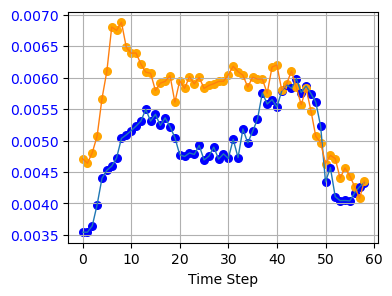

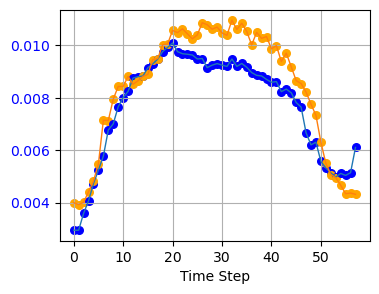

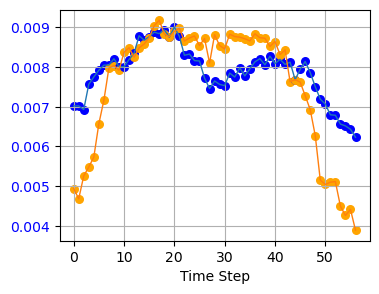

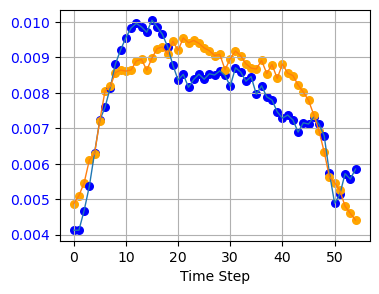

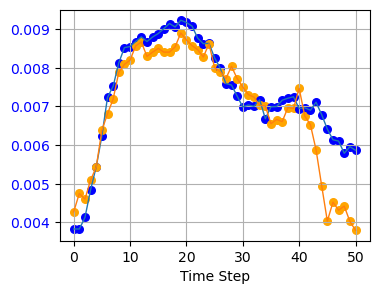

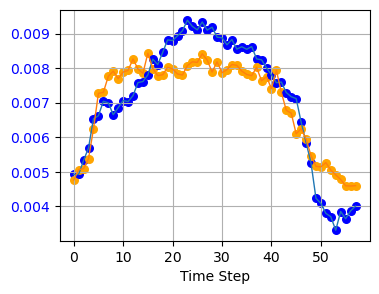

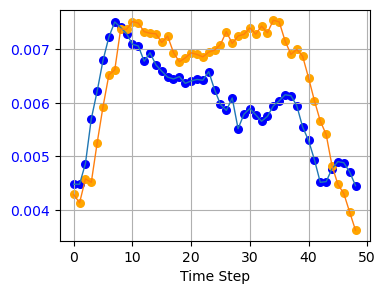

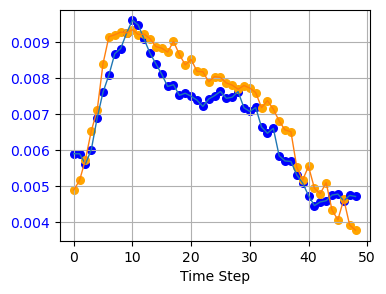

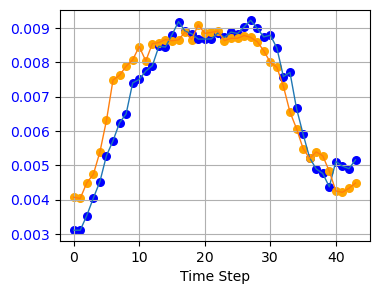

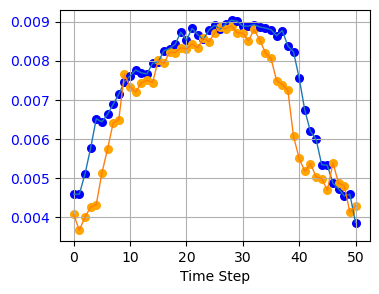

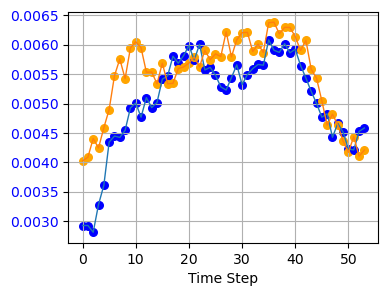

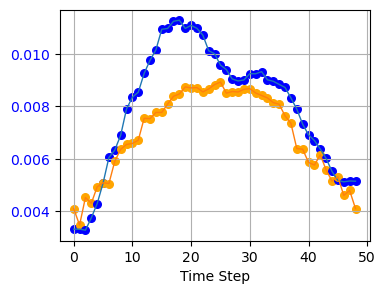

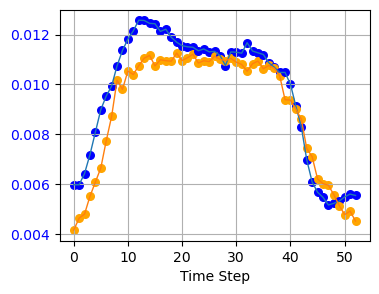

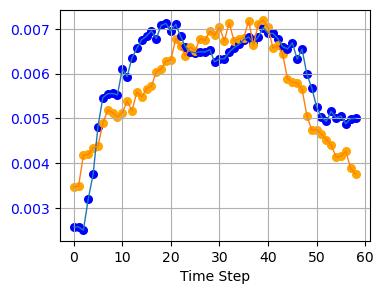

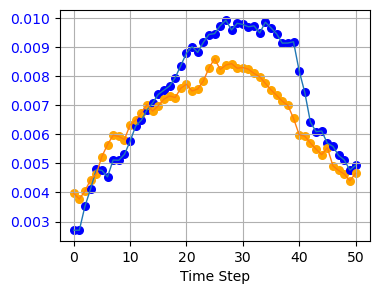

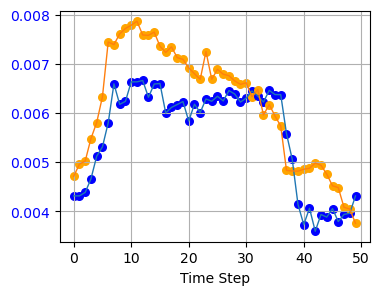

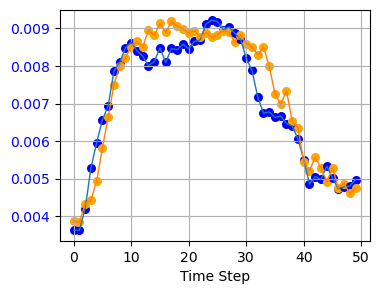

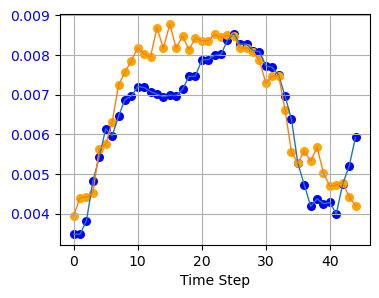

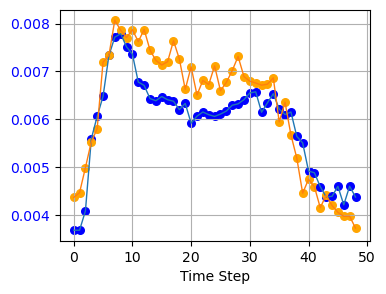

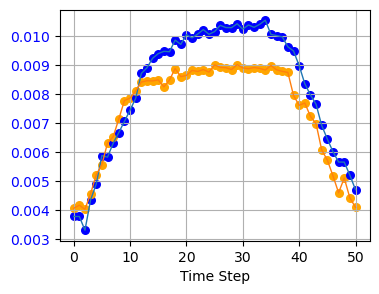

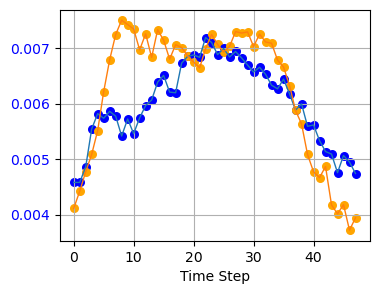

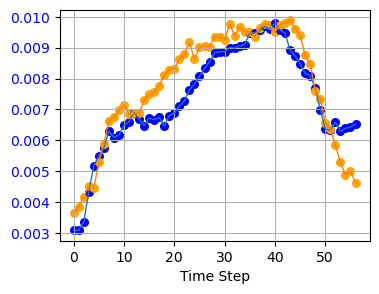

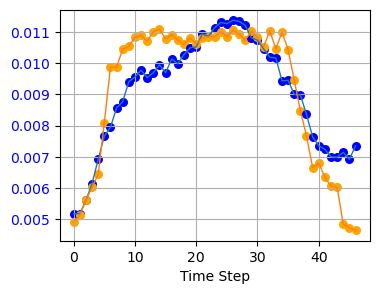

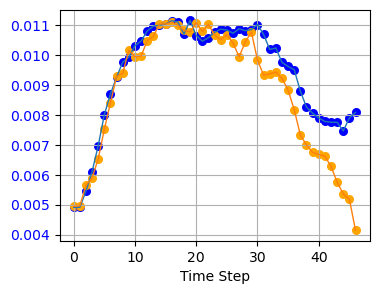

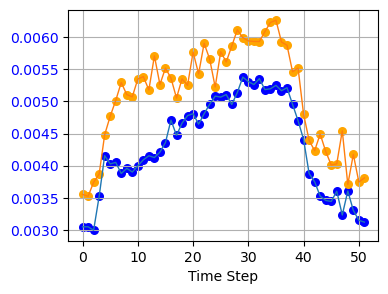

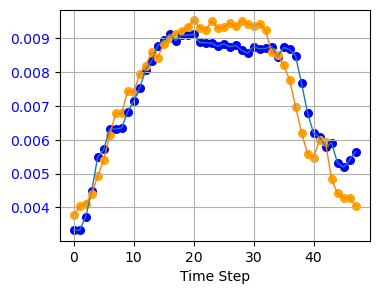

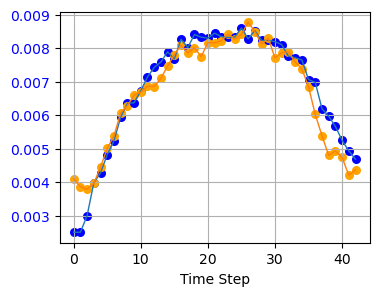

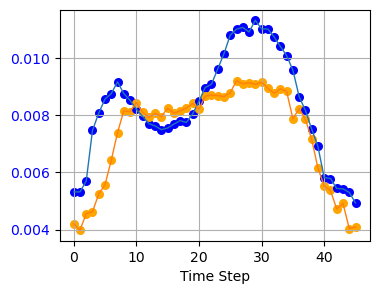

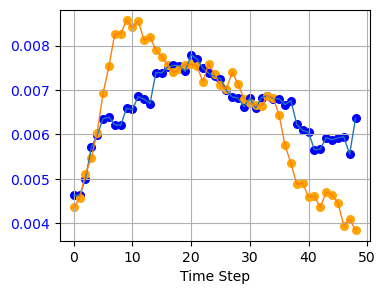

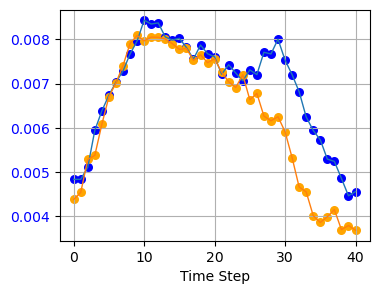

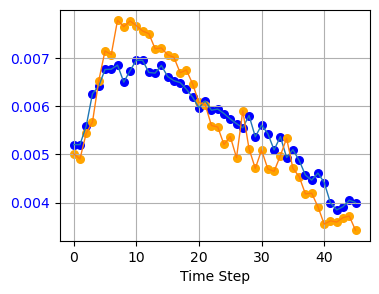

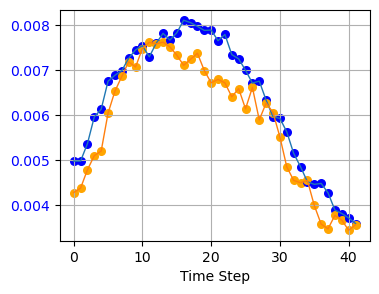

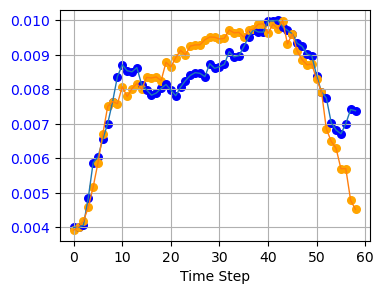

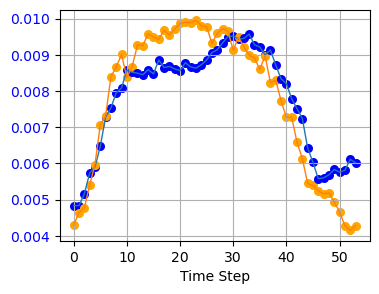

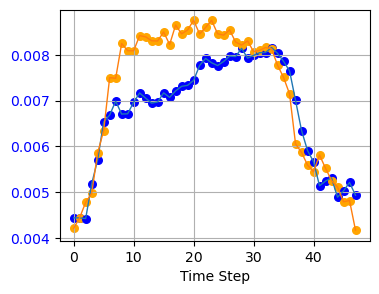

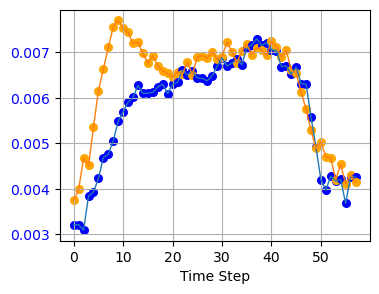

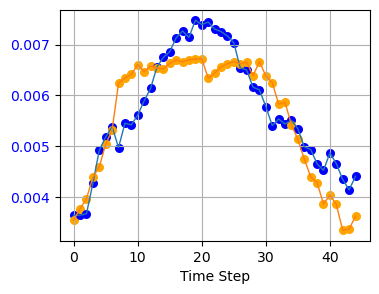

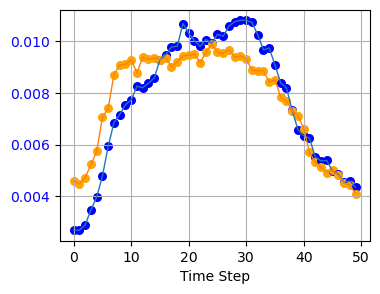

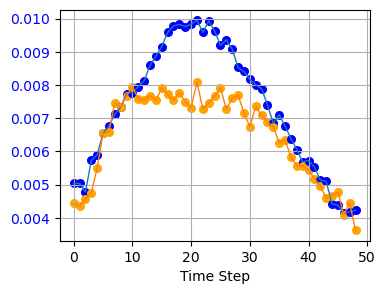

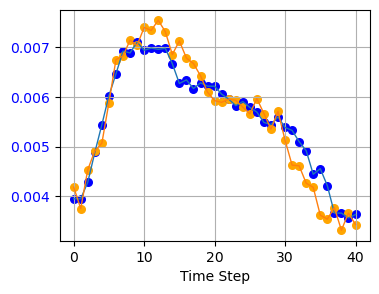

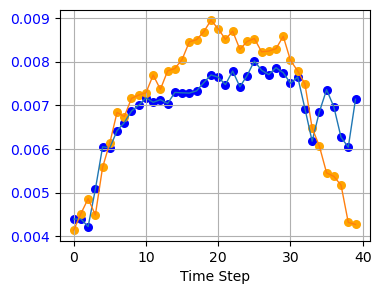

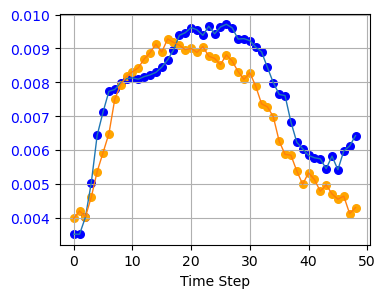

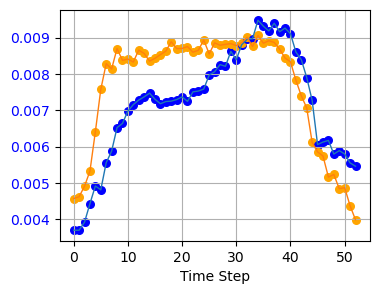

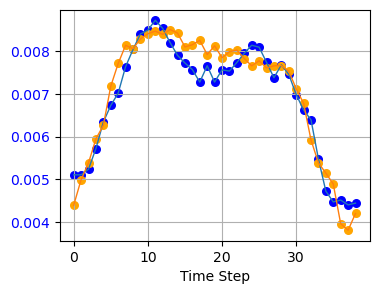

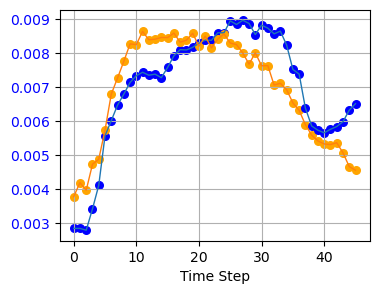

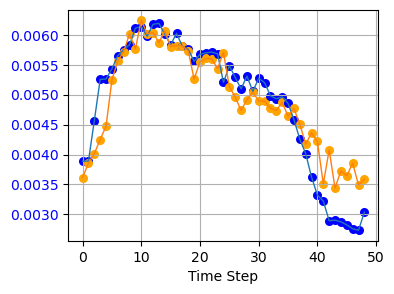

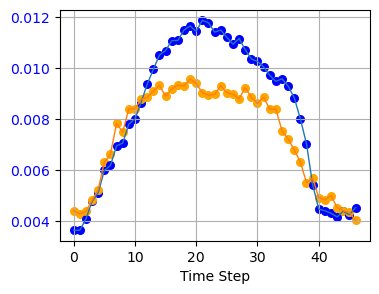

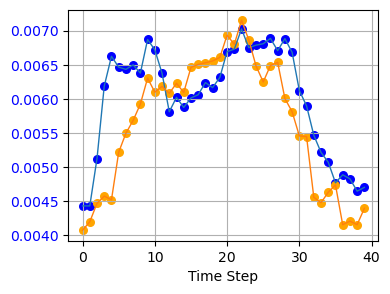

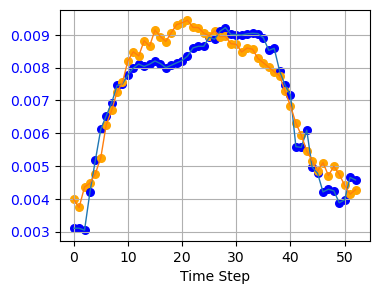

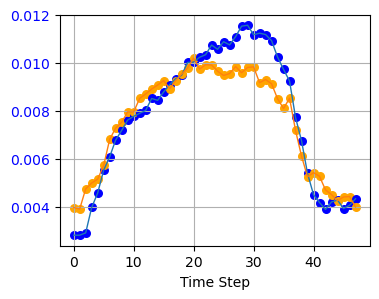

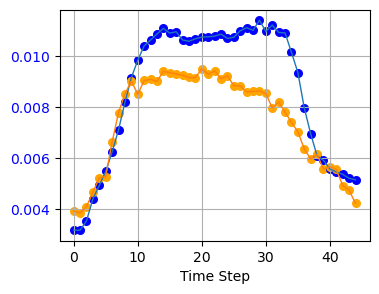

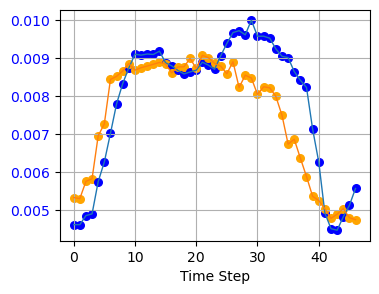

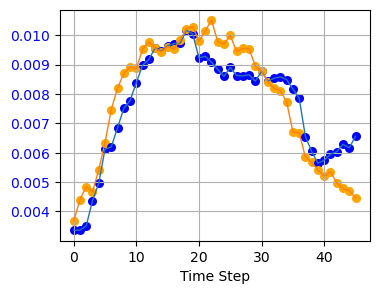

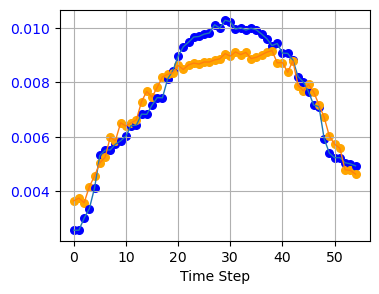

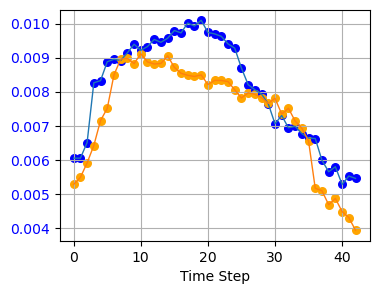

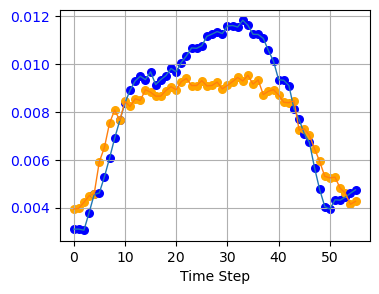

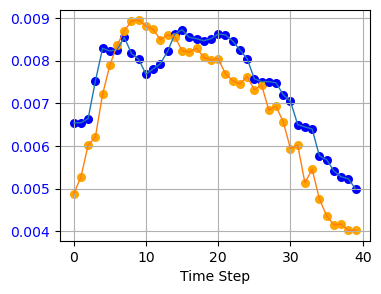

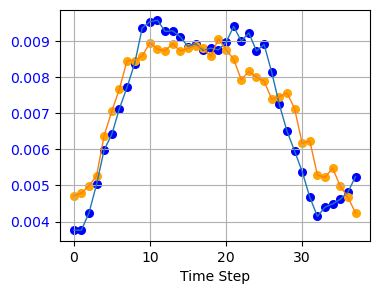

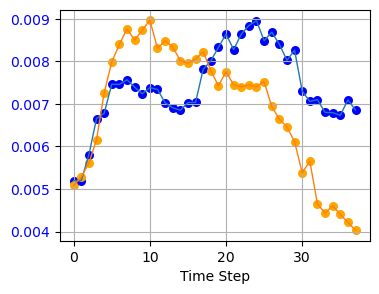

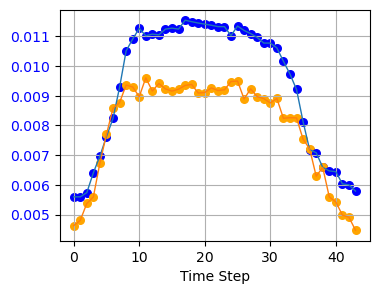

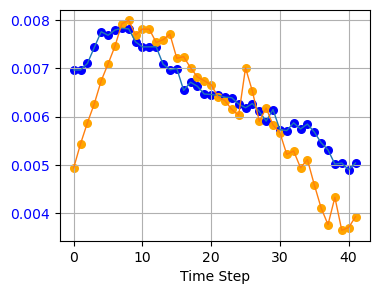

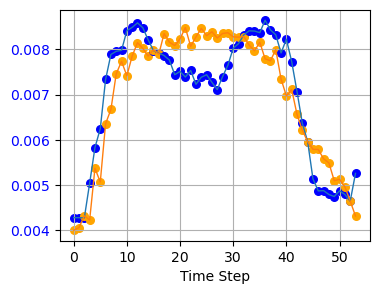

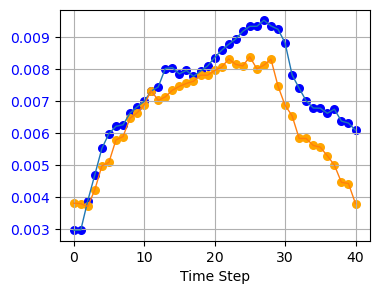

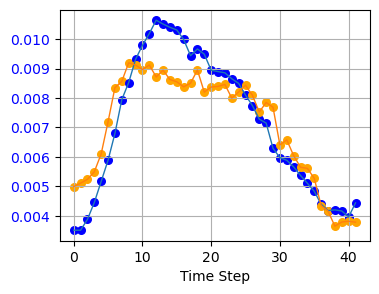

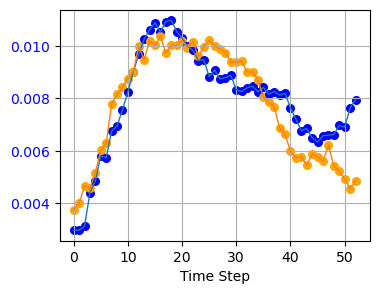

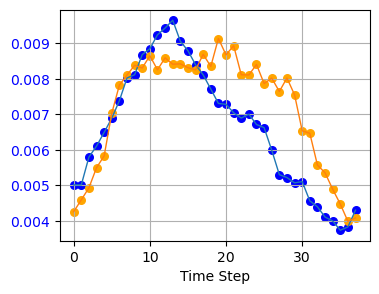

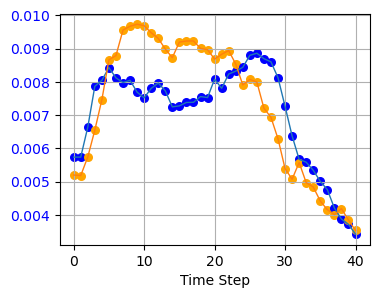

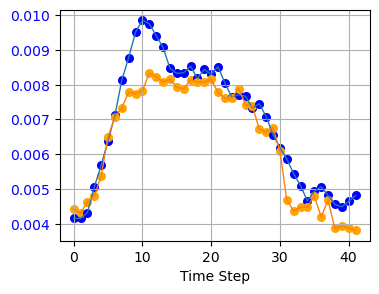

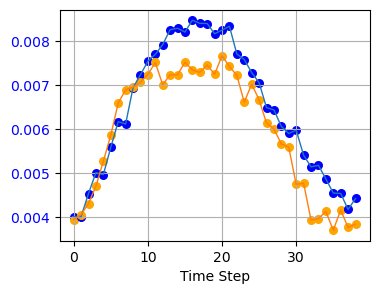

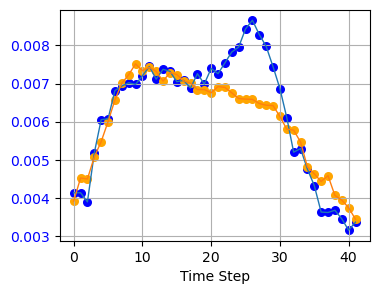

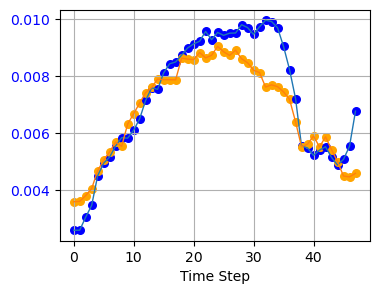

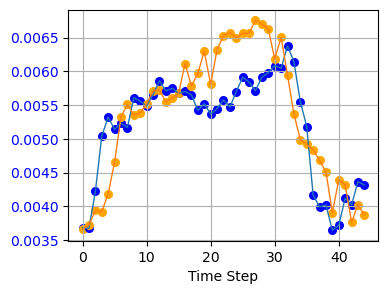

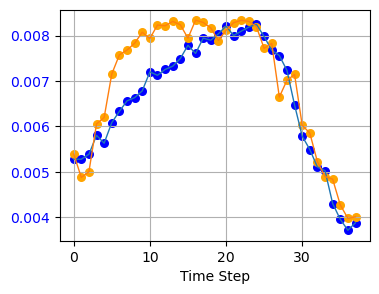

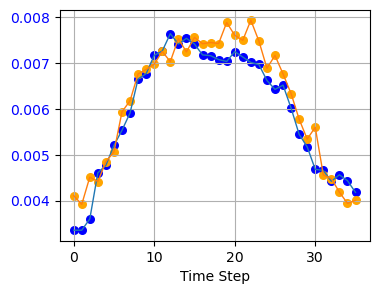

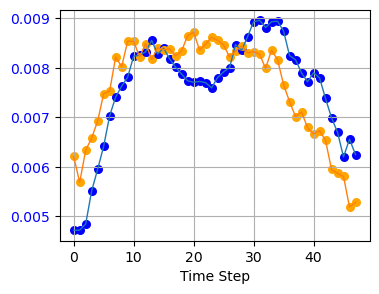

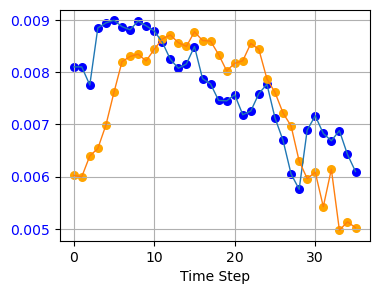

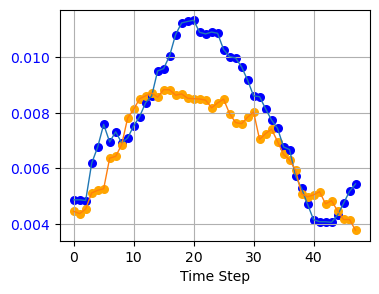

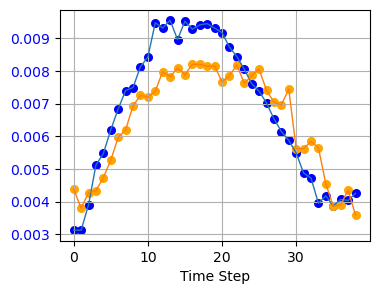

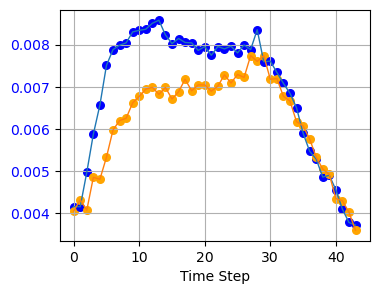

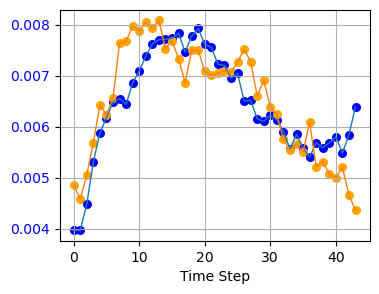

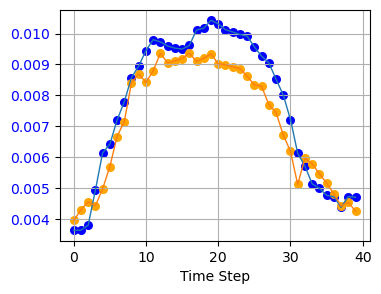

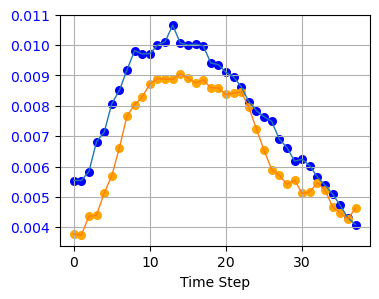

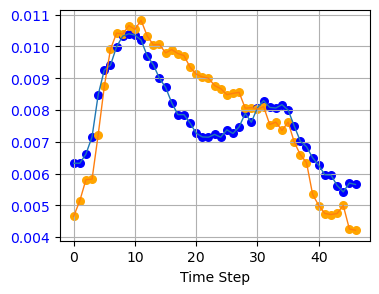

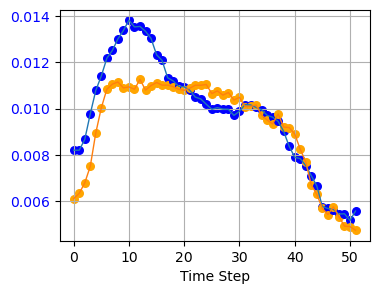

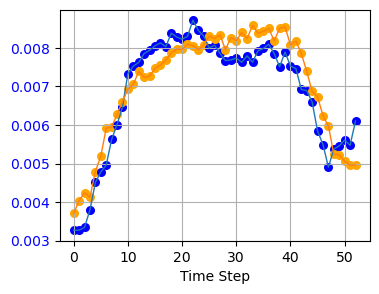

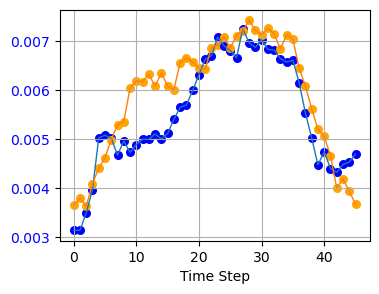

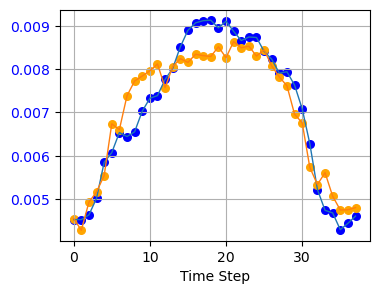

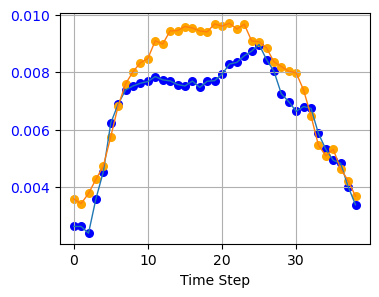

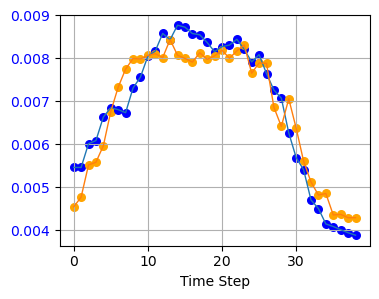

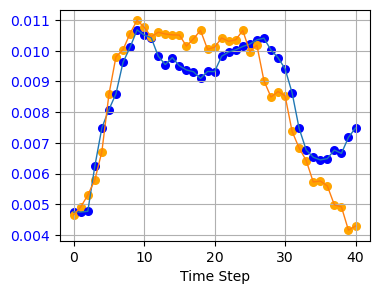

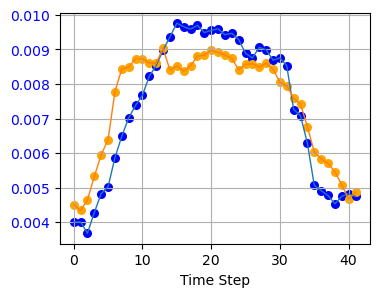

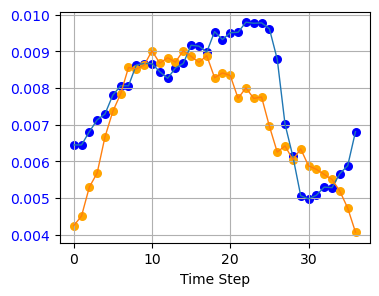

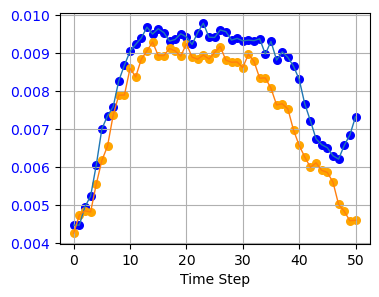

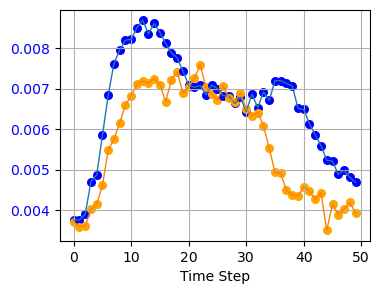

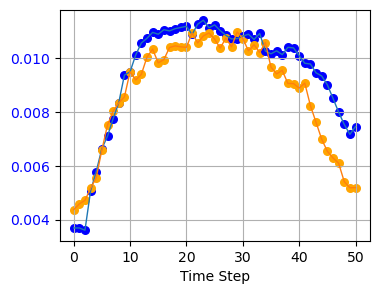

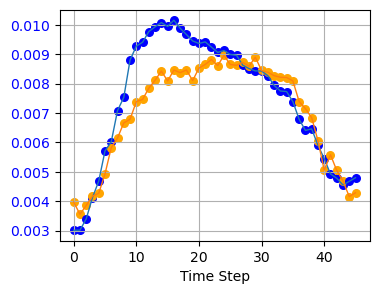

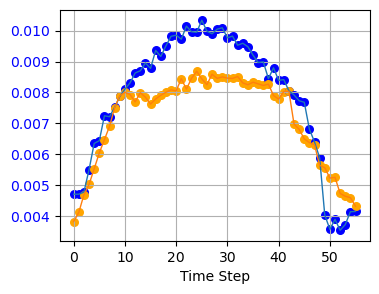

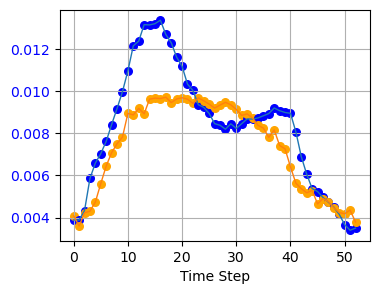

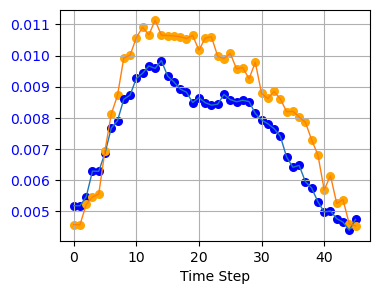

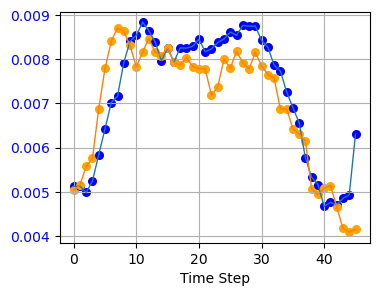

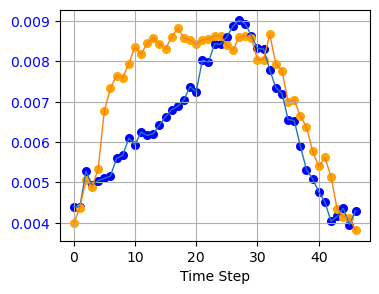

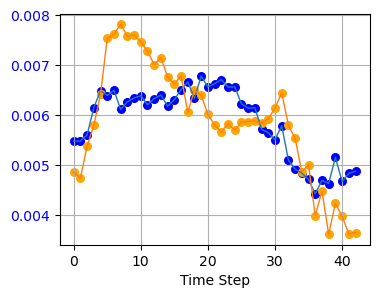

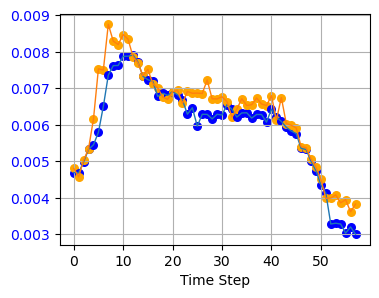

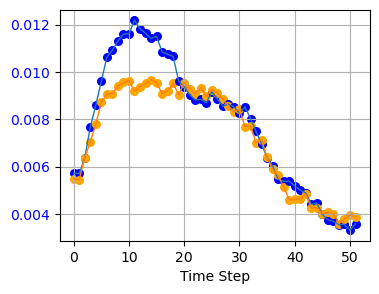

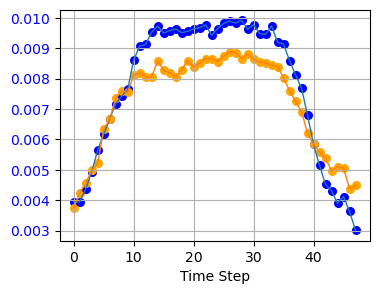

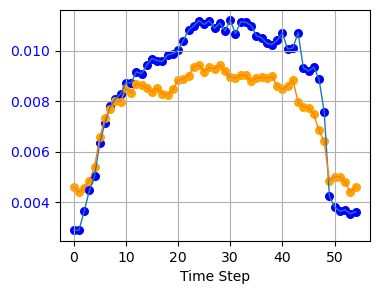

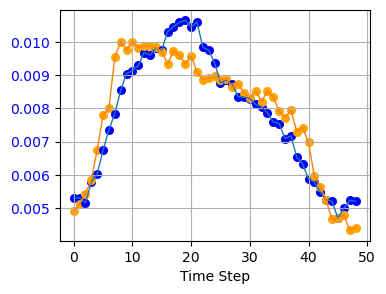

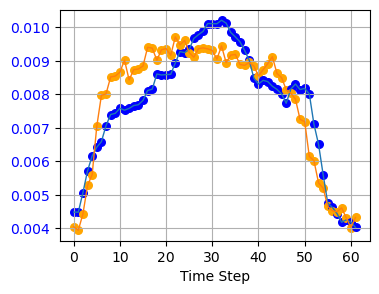

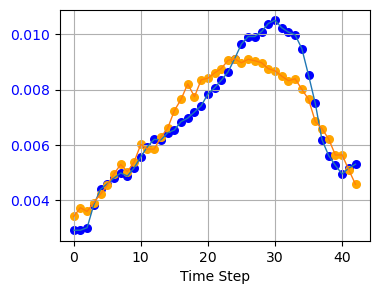

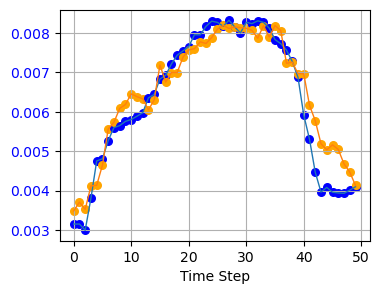

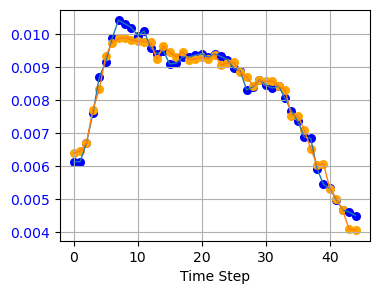

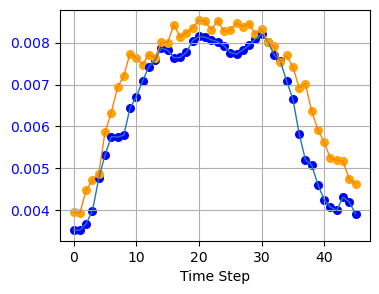

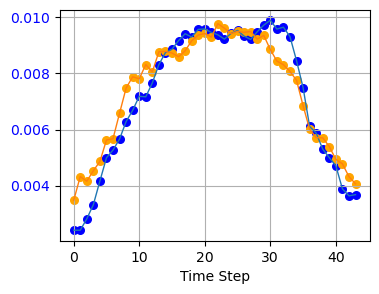

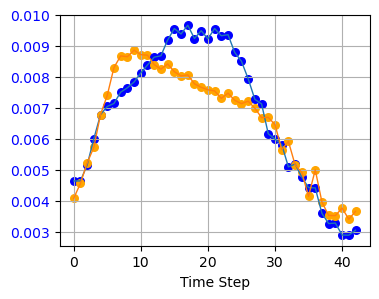

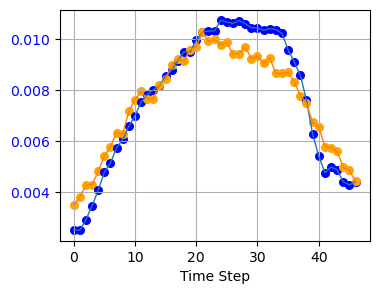

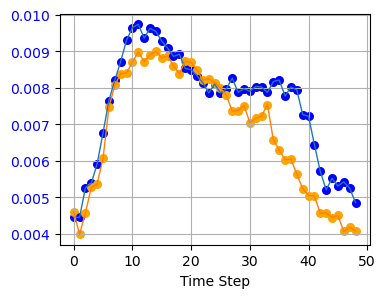

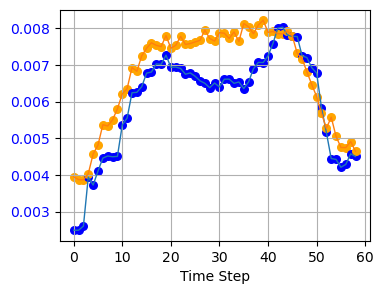

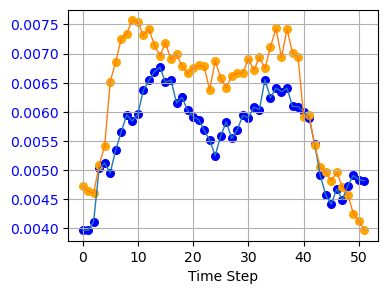

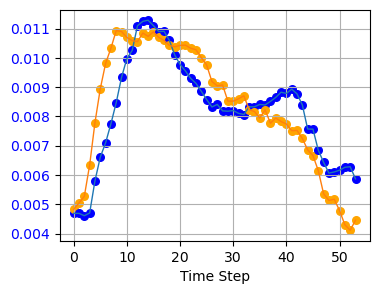

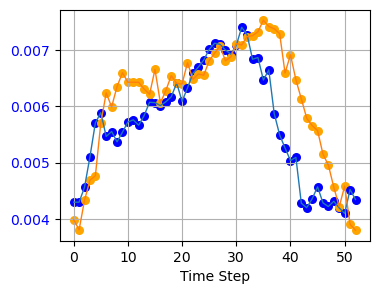

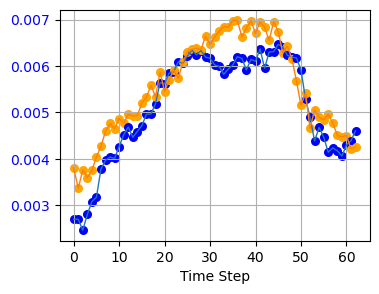

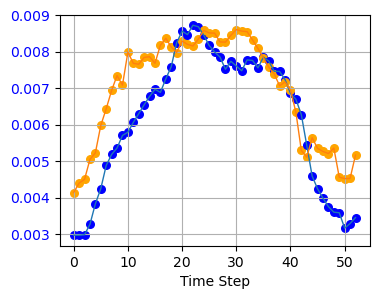

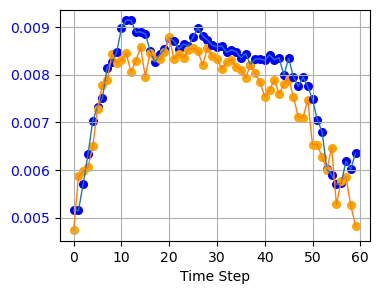

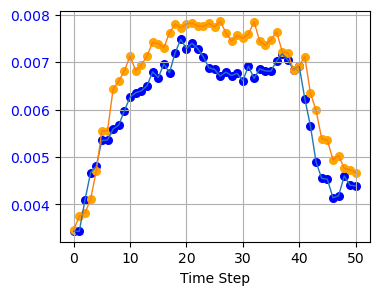

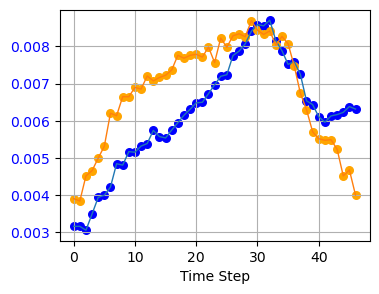

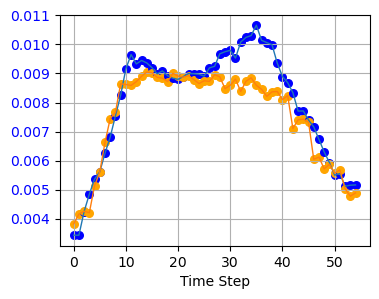

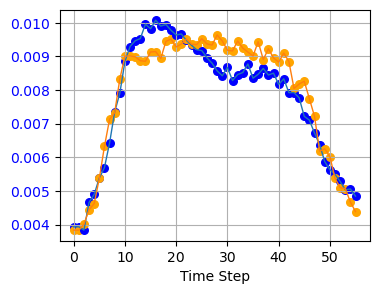

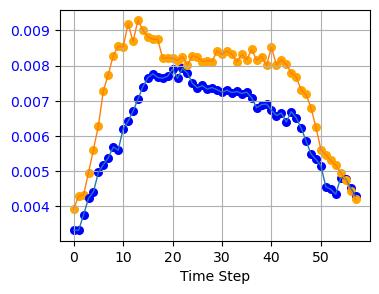

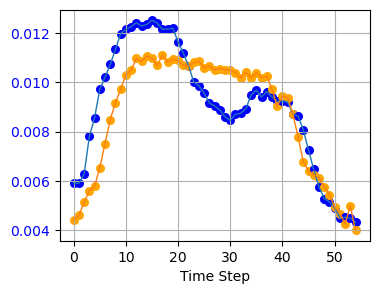

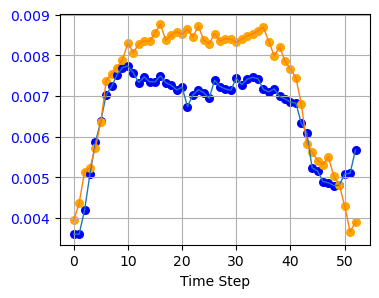

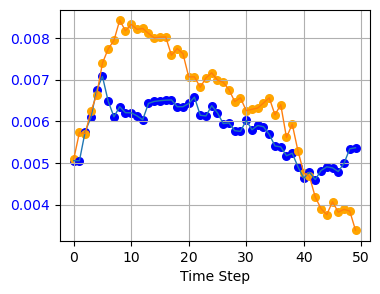

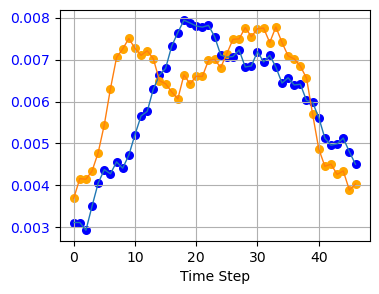

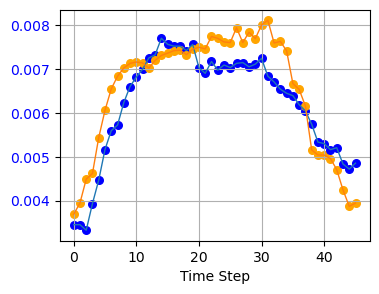

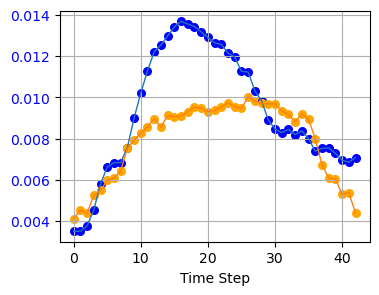

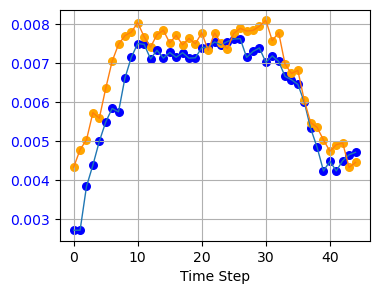

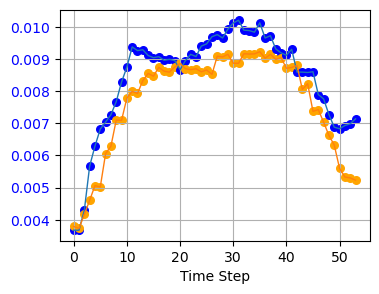

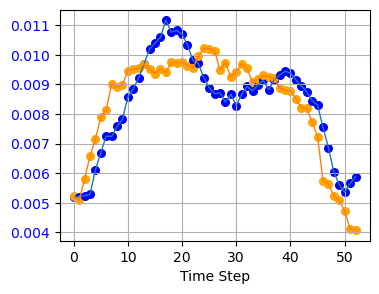

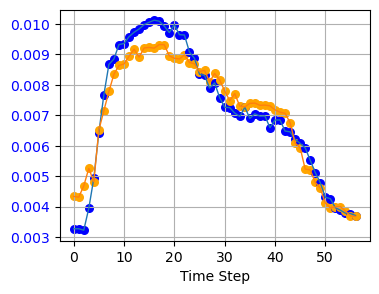

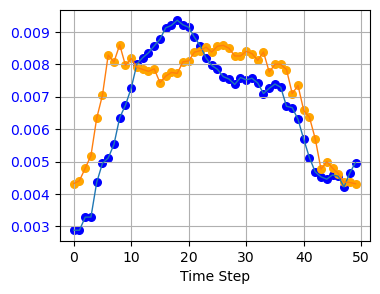

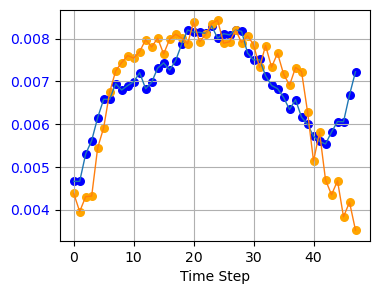

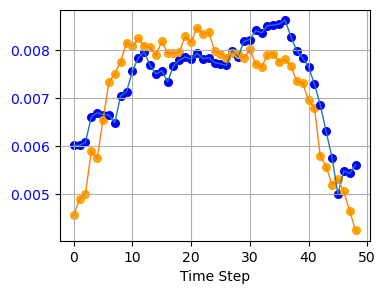

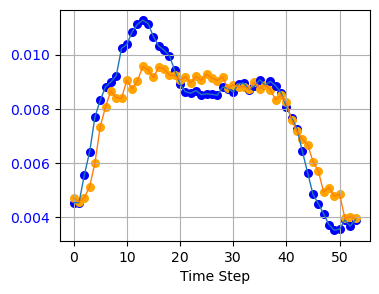

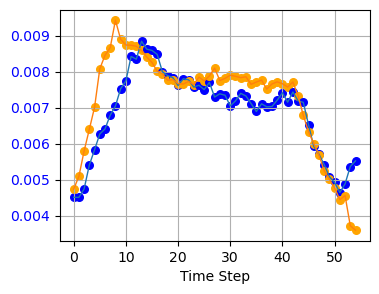

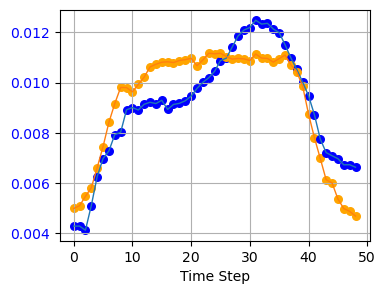

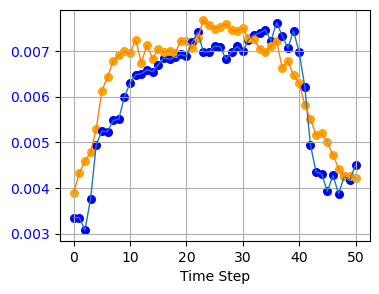

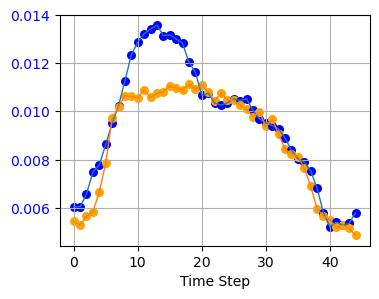

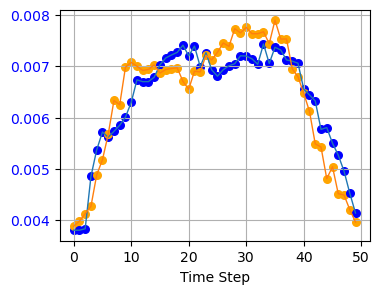

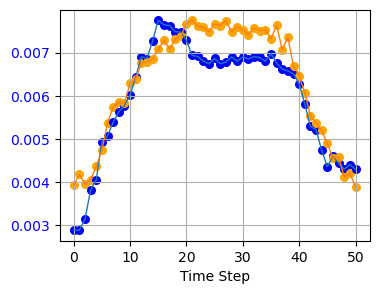

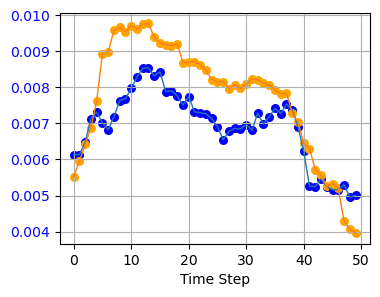

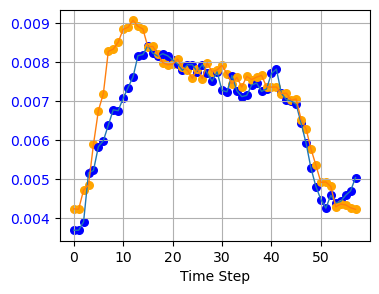

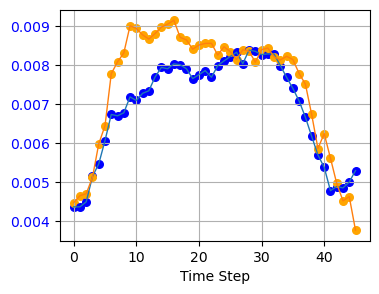

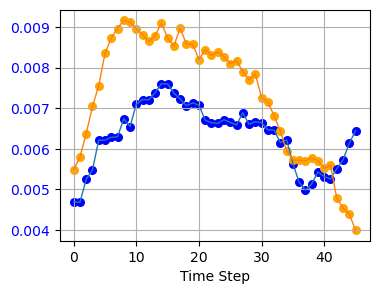

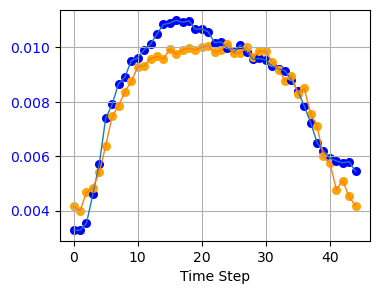

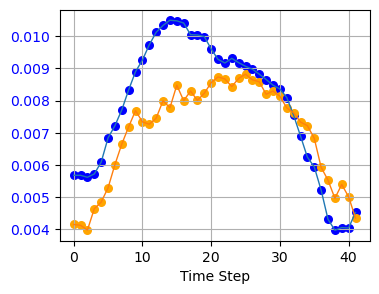

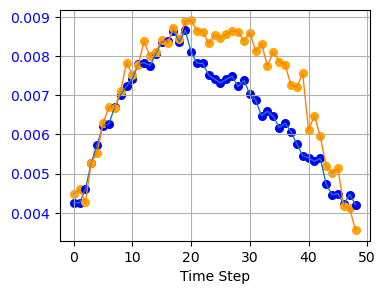

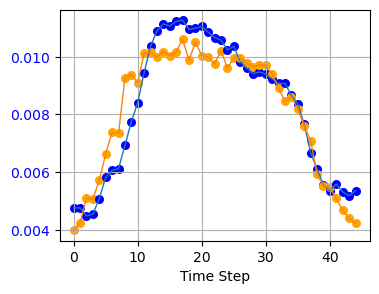

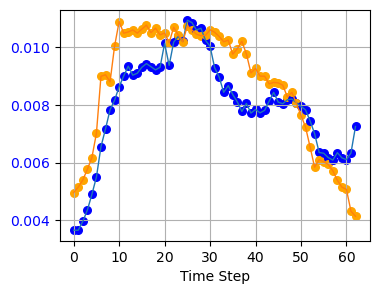

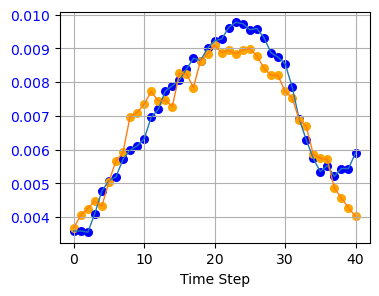

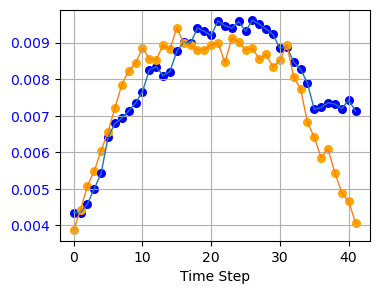

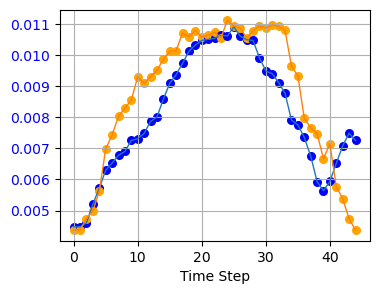

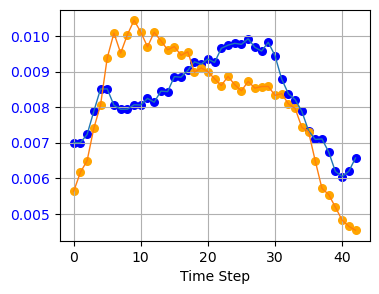

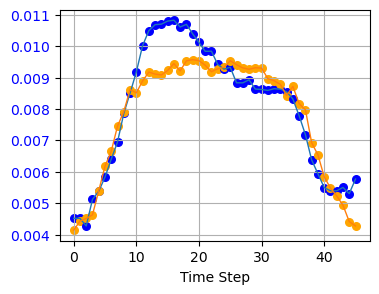

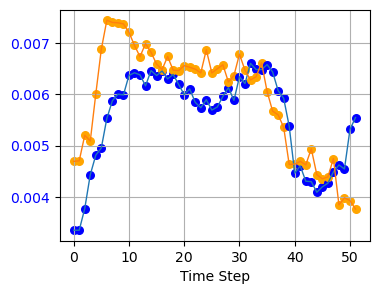

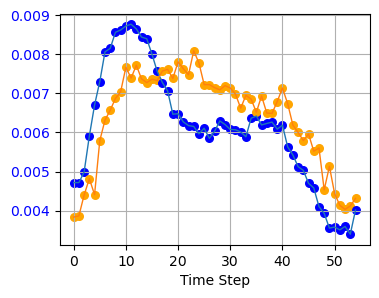

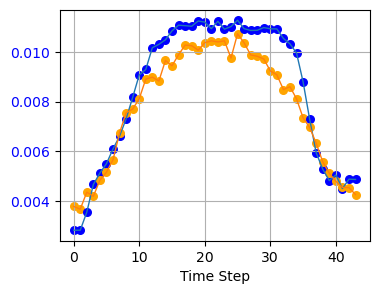

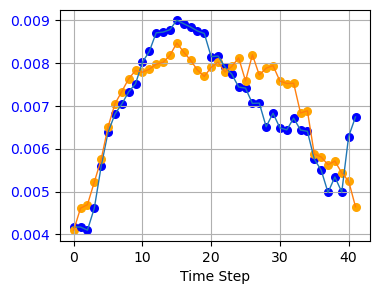

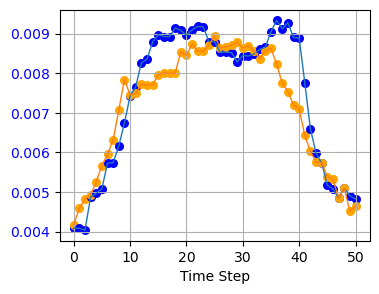

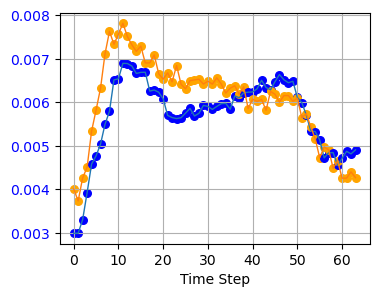

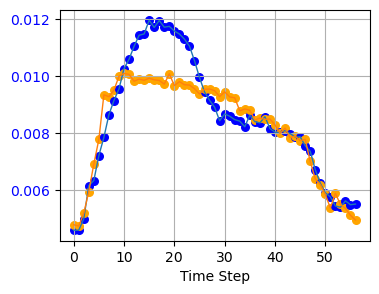

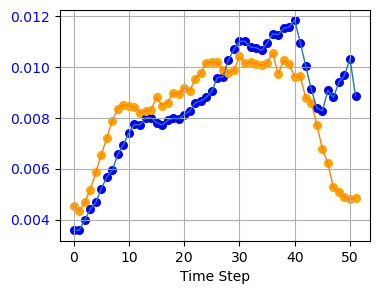

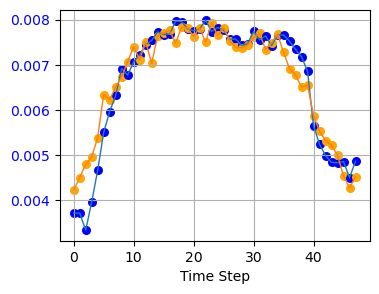

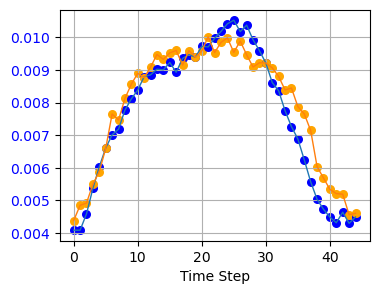

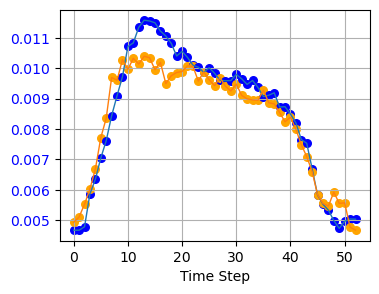

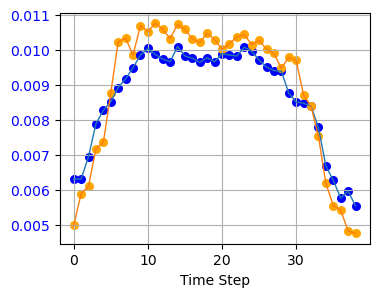

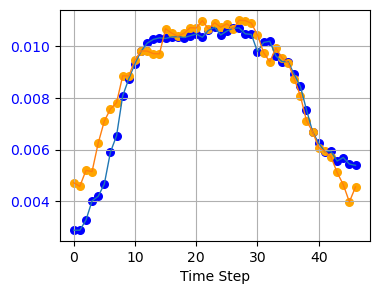

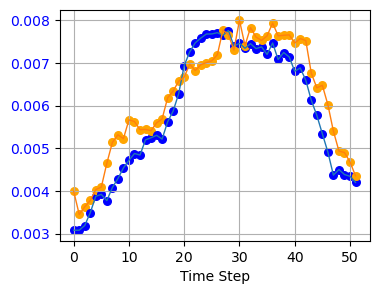

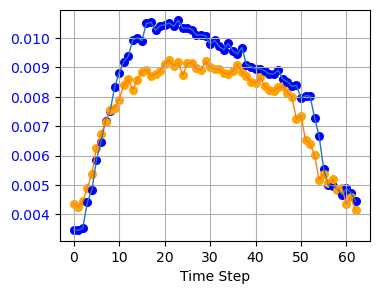

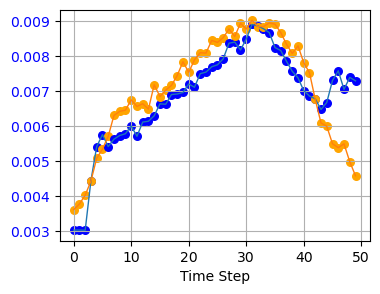

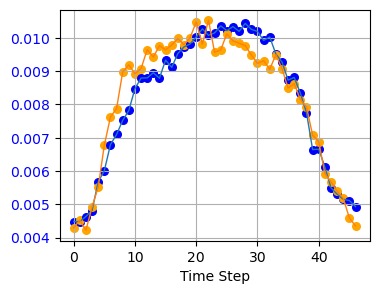

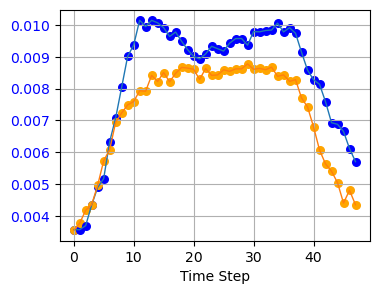

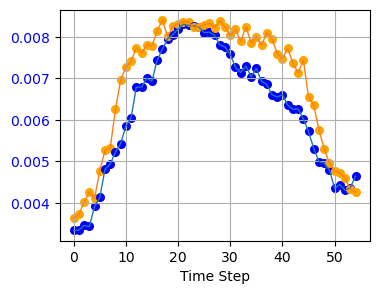

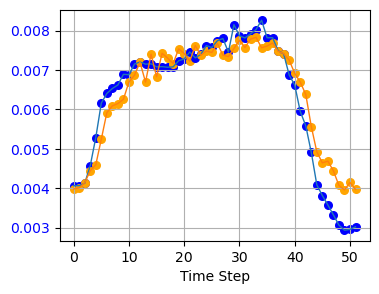

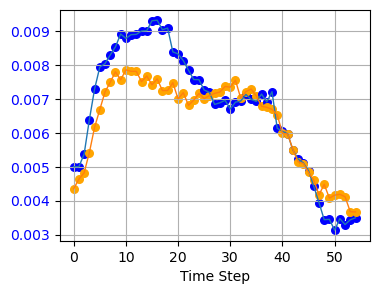

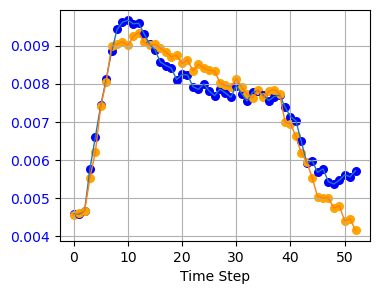

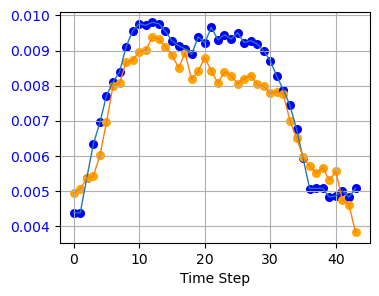

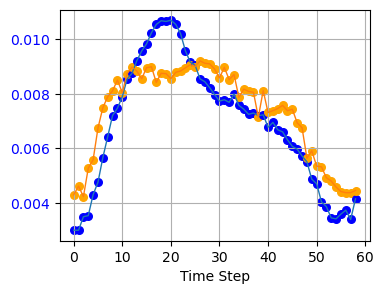

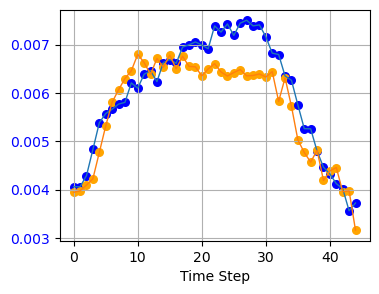

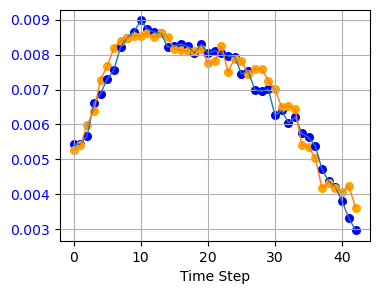

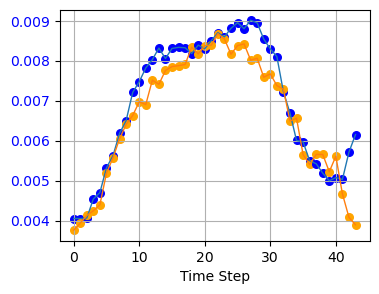

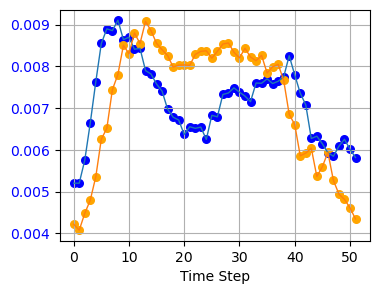

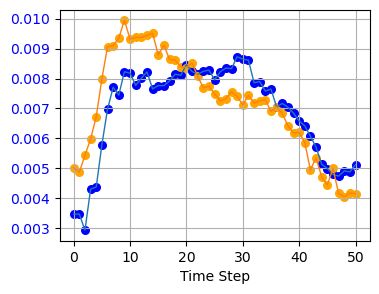

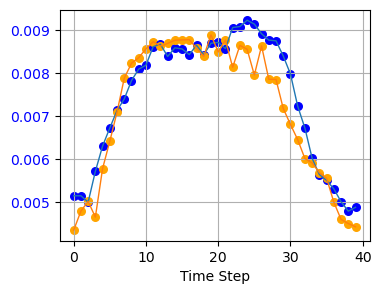

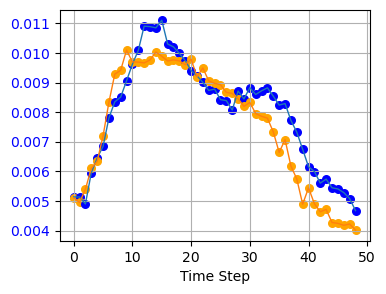

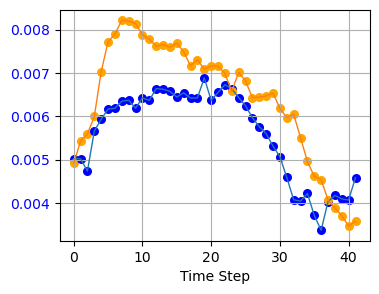

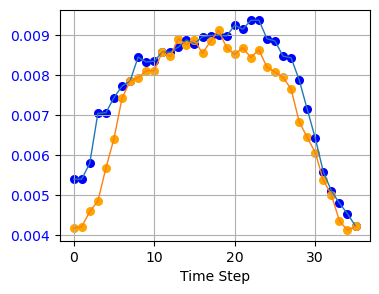

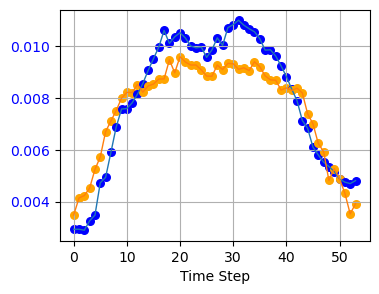

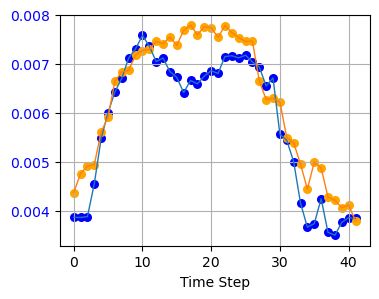

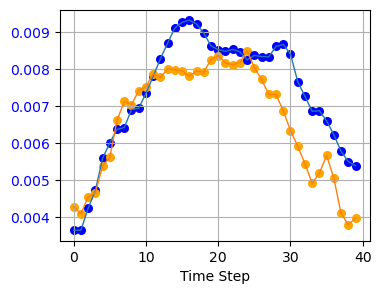

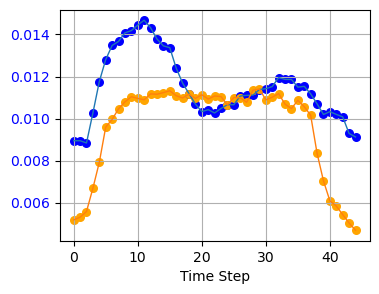

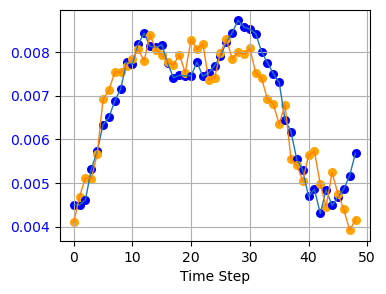

In [29]:
from PIL import Image
import h5py
from tqdm import tqdm
from moviepy.editor import ImageSequenceClip

new_dataset_path = "../data/robomimic/datasets/lift/ph/low_dim_abs_with_attention_right.hdf5"
file = h5py.File(new_dataset_path, 'r')
num_demos = len(file['data'].keys())

video_dir = "../data/robomimic/datasets/lift/ph/videos_with_spatial_attention_validate"
os.makedirs(video_dir, exist_ok=True)

sample = next(iter(img_dataloader))

_, _, C, H, W = sample['obs']['agentview_image'].shape

img_iterator = iter(img_dataloader)
lowdim_iterator = iter(display_dataloader)

for i in tqdm(range(num_demos)):
    demo_key = f'data/demo_{i}'
    demo = file[demo_key]
    num_samples = demo.attrs['num_samples']
    
    imgs = np.zeros((num_samples, H, 2*W, C), dtype=np.uint8)
    
    spatial_attention = list()
    gt_spatial_attention = list()
    for sample_idx in tqdm(range(num_samples), leave=False):        
        sample = next(img_iterator)
        batch = next(lowdim_iterator)
        
        # Transpose from (3,84,84) to (84,84,3) format
        imgs[sample_idx, :, :W, :] = ((sample['obs']['agentview_image'][0, 0].permute(1, 2, 0) * 255).numpy()).astype(np.uint8)
        imgs[sample_idx, :, W:, :] = (sample['obs']['robot0_eye_in_hand_image'][0, 0].permute(1, 2, 0) * 255).numpy().astype(np.uint8)
        
        assert np.linalg.norm(sample['obs']['object'][0, 1, :].numpy()-demo['obs']['object'][sample_idx]) < 1e-4 #check if this is sync well with the dataset
        
        B, T, D = batch['obs'].shape
        nobs = normalizer['obs'].unnormalize(batch['obs']).to(device)
        naction = normalizer['action'].unnormalize(batch['action']).to(device)
        
        obs = nobs[:, :2, :-1].reshape(B, -1).to(device)
        action_seq = naction.to(device)
        attention = nobs[:, :, -1].unsqueeze(-1).to(device)
        
        with torch.no_grad():
            output = model(obs, action_seq).detach()
            attention_pred = normalizer['obs'].normalize(torch.cat([nobs[:, :, :-1], output], dim=-1))[:, :, -1].detach().cpu().numpy()
        spatial_attention.append(attention_pred[0, 0])
        gt_spatial_attention.append(batch['obs'][0, 0, -1])
        
    spatial_attention = np.array(spatial_attention)
    next(img_iterator) # Fro syncing
    next(lowdim_iterator)
            
    # Get attention graph images
    fig, ax = plt.subplots(figsize=(4, 3))
    time_steps = np.arange(len(spatial_attention))
    ax.plot(time_steps, gt_spatial_attention, 'b-', color='tab:blue', linewidth=1, label='Spatial Attention')
    ax.plot(time_steps, spatial_attention, 'b-', color='tab:orange', linewidth=1, label='Spatial Attention')
    ax.set_xlabel('Time Step')
    ax.tick_params(axis='y', labelcolor='b')
    ax.grid(True)
    graph_frames = list()
    for t in range(len(gt_spatial_attention)):
        ax.scatter(t, gt_spatial_attention[t], color='blue', s=30)
        ax.scatter(t, spatial_attention[t], color='orange', s=30)
        
        fig.canvas.draw()
        graph_img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        graph_img = graph_img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        graph_frames.append(graph_img)
    graph_height, graph_width = graph_frames[0].shape[:2]
    # prepare combined frames
    
    # attention_data = get_spatial_attention_from_episode(epi)
    combined_frames = list()
    for frame, graph in zip(imgs, graph_frames):
        # Resize frame to match graph height
        frame_height, frame_width = frame.shape[:2]
        aspect_ratio = frame_width / frame_height
        new_height = graph_height
        new_width = int(new_height * aspect_ratio)
        
        frame_resized = np.array(Image.fromarray(frame).resize((new_width, new_height)))
        
        # Create canvas and center the frame
        canvas = np.zeros((graph_height, graph_width+new_width, 3), dtype=np.uint8)
        
        canvas[:, :new_width, :] = frame_resized
        canvas[:, new_width:, :] = graph
        combined_frames.append(canvas)
        
    video_path = os.path.join(video_dir, f"episode_{i}.mp4")
    
    # Create and write video with moviepy
    clip = ImageSequenceClip(combined_frames, fps=10)
    clip.write_videofile(video_path, codec='libx264')